<div style=" background-color: RGB(0,114,200);" >
<h1 style="margin: auto; padding: 20px 0; color:#fff; text-align: center">PROJET 9 DATA ANALYST</h1>
<h2 style="margin: auto; padding: 20px 0; color:#fff; text-align: center">Produisez une étude de marché avec R ou Python
</h2>
</div>

Ce notebook est le second des deux notebooks qui composent notre étude de marché. Il contient l'analyse des groupements de pays en utilisant la classification ascendante hiérarchique et la méthode des k-means. Il contient également une ACP afin de visualier les résultats de l'analyse.

Nous sommes en poste chez La poule qui chante, une entreprise française d’agroalimentaire qui souhaite se développer à l'international. Cependant, la liste des pays potentiels dans lesquels s'implanter est longue. Pour cela, nous allons réaliser une analyse des groupements de pays que l'on pourra cibler grâce à différentes méthodes de clustering, puis nous approfondirons l'étude de marché.

Le jeu de données qui va être utilisé est celui déja préparé dans le premier notbook. Il contient différents indicateurs sélectionnés ou calculés par nous mêmes pour  mener à bien notre mission.

# Sommaire
1. [ Importation des librairies et des données](#paragraph1)
2. [ Clustering](#paragraph2)
    1. [ Classification k-means ](#subparagraph1)
    2. [ Classification Ascendante Hiérarchique (CAH) ](#subparagraph1)
    3. [ Comparaison des résultats des deux méthodes ](#subparagraph1)
3. [ Analyse en Composantes Principales (ACP)](#paragraph2)
    1. [Varience expliquée par chaque composantes principale](#subparagraph1)
    2. [ Cercle des corrélations ](#subparagraph2)
    3. [Représentation des individus sur les plans factoriels PC1 et PC2](#subparagraph3)
4. [ Recommandations ciblées](#paragraph2)



# Importation des librairies et des données

In [1]:
#Importation des la librairies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


Nous allons importer le  dataset des indicateurs des pays que nous avons déja généré dans le premier notbook.

In [2]:
#Importation et affichage des premieres lignes 
df_final = pd.read_csv('indicateurs-pays-2017.csv')
df_final.head(3)

,Zone,population_milliers_hab,Taux_Croissance,Consommation_Volailles_moyenne_Par_Personne (kg/personne/ans),Ratio_Importation_Consommation,Ratio_Production_Consommation,Taux_Dependance_Import,PIB_personne_US$,indice_stabilite_politique
0,Afrique du Sud,57009.756,1.403732,35.69,25.261980,81.929418,24.27,6723.928582,-0.28
1,Albanie,2884.169,-0.454795,16.36,80.534060,27.551126,74.51,4521.752217,0.38
2,Algérie,41389.189,1.724390,6.38,0.757395,104.141804,0.72,4134.936055,-0.92


# Clustering

## Classification k-means


La première méthode que nous allons utiliser est la classification k-means en suivant le plan suivant :
    
1) Rappel

2) Etape 1 : 
    Application de l'algorithme des k means : Tester différents scalers et différents nombres de clusters choisies arbitrairement 
    
3) Etape 2 :
    Application de l'algorithme des k means : Tester plusieurs scalers et appliquer la méthode du coude pour détérminer le nombre de clusters optimal.
    
4)  Comparaison des résultats des deux étapes et choix des meilleurs condidats (combinaisons) 

**1 ) Rappel :**

**Principe de Base :**

La classification k-means regroupe les individus en cherchant à minimiser l'inertie intraclasse de chaque groupe. Pour cela, l'algorithme utilise les centres de gravité (centroïdes) des groupes. Au départ, les centroïdes sont placés aléatoirement puis, ils sont recaculés à chaque itération jusqu'à ce que les résultats de l'algorithme convergent.

Pour choisir le nombre optimal de clusters nous allons nous appuyer sur la méthode du coude dans laquelle nous allons calculer l'inertie intraclasse en fonction du nombre de groupes. On cherchera alors à déterminer à partir de quand l'augmentation du nombre de clusters n'a plus un impact significatif sur la diminution de l'inertie.

 Pour évaluez la qualité du clustering nous allons appuyer sur l'indice de silhouette, qui mesure la cohésion et la séparation des clusters. Un indice de silhouette proche de 1 indique des clusters bien séparés.

**Étapes de l'Algorithme :**

**Choix des centroides initiaux :** Sélectionnez aléatoirement k points de données comme centroïdes initiaux.

**Assignation des points aux clusters :**  Assignez chaque point de donnée au centroïde le plus proche en calculant la distance euclidienne entre le point et les centroïdes. Chaque point de donnée est assigné au cluster dont le centroïde est le plus proche.

**Recalcul des centroides :** Recalculez les positions des centroïdes en prenant la moyenne des positions des points assignés à chaque cluster.

**Répétition :** Répétez les étapes 2 et 3 jusqu'à ce que les centroïdes ne changent plus significativement (c'est-à-dire jusqu'à convergence).

**2) Etape 1 :**

Voici comment nous allons procéder pour réaliser cette première étape :

1- Appliquer les scalers : Parcourir les scalers disponibles.

2- Appliquer K-means : Pour chaque scaler, parcourir différentes valeurs de k (nombre de clusters).

3- Stocker les résultats : Stocker les résultats pour chaque combinaison de scaler et de nombre de clusters, y compris l'indice de silhouette.

In [3]:
# Sélectionner uniquement les colonnes numériques
numeric_cols = df_final.select_dtypes(include='number').columns
df_numerical = df_final[numeric_cols]

# Définir les scalers à tester
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Nombre de clusters à tester
k_values = range(2, 11)

results = []

# Boucle sur chaque scaler et chaque nombre de clusters
for scaler_name, scaler in scalers.items():
    df_scaled = scaler.fit_transform(df_numerical)  # Appliquer le scaler
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(df_scaled)
        
        silhouette_avg = silhouette_score(df_scaled, cluster_labels) # la moyenne des indices de silhouette de toutes les observations dans les données
        
        results.append({
            'Scaler': scaler_name,
            'NumClusters': k,
            'SilhouetteScore': silhouette_avg
        })

C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

In [4]:
# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Afficher les résultats
print(results_df)

            Scaler  NumClusters  SilhouetteScore
0   StandardScaler            2         0.301241
1   StandardScaler            3         0.289500
2   StandardScaler            4         0.267957
3   StandardScaler            5         0.270994
4   StandardScaler            6         0.243569
5   StandardScaler            7         0.254173
6   StandardScaler            8         0.228384
7   StandardScaler            9         0.236061
8   StandardScaler           10         0.243221
9     MinMaxScaler            2         0.372771
10    MinMaxScaler            3         0.303826
11    MinMaxScaler            4         0.275718
12    MinMaxScaler            5         0.251395
13    MinMaxScaler            6         0.246273
14    MinMaxScaler            7         0.206253
15    MinMaxScaler            8         0.214448
16    MinMaxScaler            9         0.227052
17    MinMaxScaler           10         0.225180
18    RobustScaler            2         0.541768
19    RobustScaler  

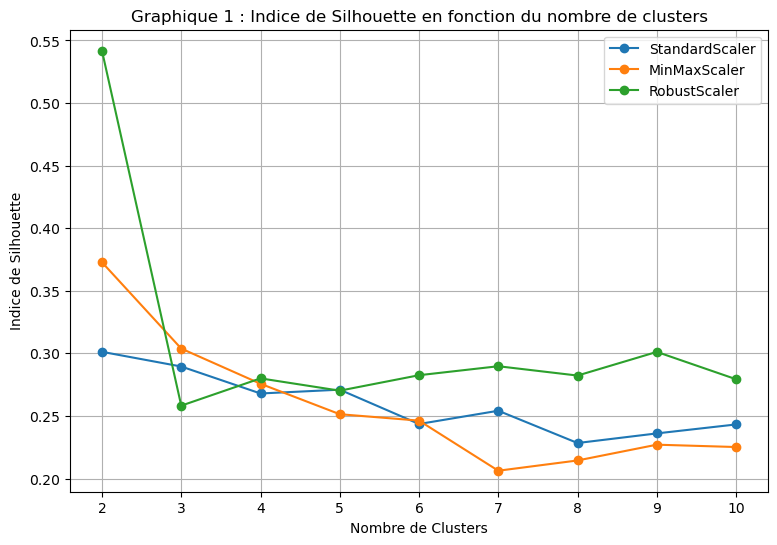

In [5]:
# Tracer les résultats pour chaque scaler
plt.figure(figsize=(9, 6))

for scaler_name in scalers.keys():
    subset = results_df[results_df['Scaler'] == scaler_name]
    plt.plot(subset['NumClusters'], subset['SilhouetteScore'], marker='o', label=scaler_name)

plt.xlabel('Nombre de Clusters')
plt.ylabel('Indice de Silhouette')
plt.title('Graphique 1 : Indice de Silhouette en fonction du nombre de clusters')
plt.legend()
plt.grid(True)
plt.show()

**3) Etape 2 :**

Voici comment nous allons procéder pour cette deuxième étape :

1- Appliquer différents scalers.

2- Parcourir différentes valeurs de k (nombre de clusters).

3- Stocker l'inertie pour chaque nombre de clusters.

4-Tracer la courbe du coude pour chaque scaler.

5-Déterminer la meilleure combinaison de scalers/nombre de scalers optimal et refaire un kmeans avec.

In [6]:
# Liste des scalers à tester
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Liste pour stocker les résultats
results = []

# Parcourir les scalers
for scaler_name, scaler in scalers.items():
    # Appliquer le scaler aux données
    df_scaled = scaler.fit_transform(df_final.select_dtypes(include='number'))
    
    # Stocker l'inertie pour chaque valeur de k
    inertias = []
    
    # Parcourir différentes valeurs de k (nombre de clusters)
    for k in range(2, 11):
        # Appliquer K-means
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df_scaled)
        
        # Stocker l'inertie
        inertias.append(kmeans.inertia_)
    
    # Stocker les résultats pour le tracé
    results.append({
        'Scaler': scaler_name,
        'Inertias': inertias
    })



C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

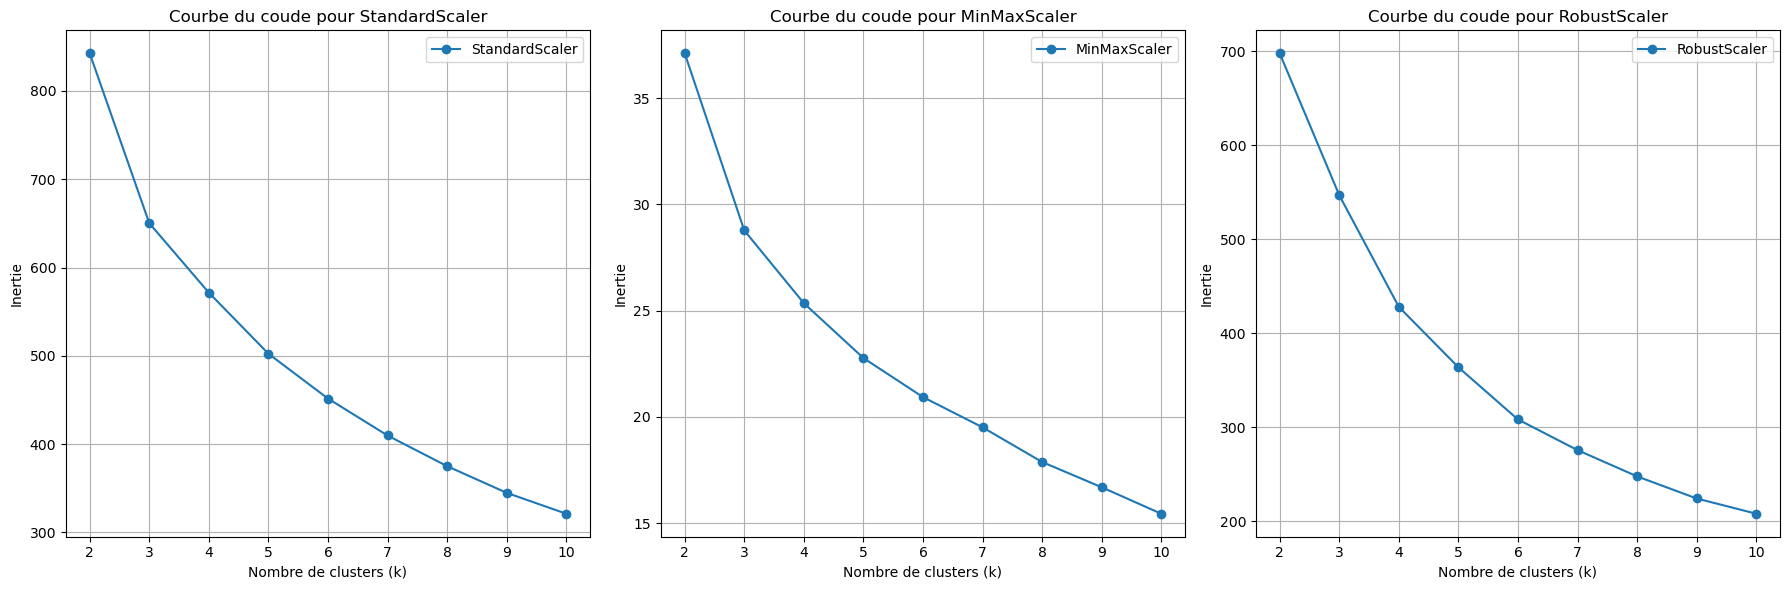

In [7]:
# Tracer la courbe du coude pour chaque scaler 
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes = axes.flatten()
for i, result in enumerate(results):
    ax = axes[i]
    ax.plot(range(2, 11), result['Inertias'], marker='o', label=result['Scaler'])
    ax.set_title(f'Courbe du coude pour {result["Scaler"]}')
    ax.set_xlabel('Nombre de clusters (k)')
    ax.set_ylabel('Inertie')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


Déterminer le coude sur la courbe du coude (ou courbe d'inertie) consiste à identifier le point où l'inertie commence à diminuer moins rapidement. Ce point représente le compromis optimal entre la réduction de l'inertie et le nombre de clusters. Donc, pour la suite on garde les combinaisons suivantes :

=> Pour StandarScaler : Nombre de Clusters = 3

=> Pour MinMaxScaler : Nombre de Clusters= 4

=> Pour RobustScaler : Nombre de Clusters =4 et Nombre de Clusters = 9  (comparer les deux scénarios pour évaluer la sensibilité des clusters à la granularité (le nombre de clusters) et de voir comment les segments de données se comportent à différentes échelles de clustering).

Maintenant, on procède a continuer notre analyse en appliquant les k means pour les différents combinaisons de scalers et nombre de clusters et afficher  différents résultas concernant la liste des pays par clusters, les centroides des indicateurs, et les radar plot des indicateurs. Pour ce faire on va procéder à la création d'une fonction 'create_report' qui résume tous ses résultats.


Nous allons utiliser le MinMaxscaler pour tracer les radar plot pour embellir les graphiques.

Cette fonction résume les résulats des différents combinaisons de scalers et de nombres de clusters choisis.
Les scalers utilisés sont : StandardScaler, MinMaxScaler, et RobustScaler.

La fonction affiche les centroides des clusters, crée des radar plots pour visualiser les centroides et affiche les listes des pays pour chaque cluster.

Tableau des combinaisons retenues :
           Scaler  Nombre de Clusters
0  StandardScaler                   3
1    MinMaxScaler                   4
2    RobustScaler                   4
3    RobustScaler                   9
Traitement de la combinaison : Scaler = StandardScaler, Nombre de clusters = 3


C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


La liste des pays par cluster :
Cluster 1: ['Allemagne', 'Argentine', 'Australie', 'Autriche', 'Barbade', 'Bélarus', 'Bosnie-Herzégovine', 'Canada', 'Chili', 'Chine, Taiwan Province de', 'Chypre', 'Costa Rica', 'Croatie', 'Danemark', 'Espagne', 'Estonie', "États-Unis d'Amérique", 'Fidji', 'Finlande', 'France', 'Grèce', 'Guyana', 'Hongrie', 'Irlande', 'Israël', 'Italie', 'Jamaïque', 'Japon', 'Lituanie', 'Malaisie', 'Maurice', 'Nouvelle-Zélande', 'Panama', 'Pologne', 'Portugal', 'République de Corée', 'République dominicaine', 'Roumanie', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Slovaquie', 'Slovénie', 'Suède', 'Tchéquie', 'Trinité-et-Tobago', 'Uruguay']
Cluster 2: ['Afrique du Sud', 'Algérie', 'Azerbaïdjan', 'Bangladesh', 'Belize', 'Bolivie (État plurinational de)', 'Brésil', 'Burkina Faso', 'Cambodge', 'Cameroun', 'Colombie', "Côte d'Ivoire", 'Égypte', 'El Salvador', 'Équateur', 'Eswatini', 'Éthiopie', 'Fédération de Russie', 'Guatemala', 'Honduras', 'Indonésie', "Iran (

,Cluster 1,Cluster 2,Cluster 3
population_milliers_hab,"26,902.41","47,993.16","6,054.19"
Taux_Croissance,0.48,1.81,1.56
Consommation_Volailles_moyenne_Par_Personne (kg/personne/ans),29.67,12.20,22.26
Ratio_Importation_Consommation,28.20,9.87,100.49
Ratio_Production_Consommation,112.47,101.38,25.98
Taux_Dependance_Import,24.11,9.44,81.68
PIB_personne_US$,"26,079.62","3,381.90","8,383.71"
indice_stabilite_politique,0.55,-0.76,0.14


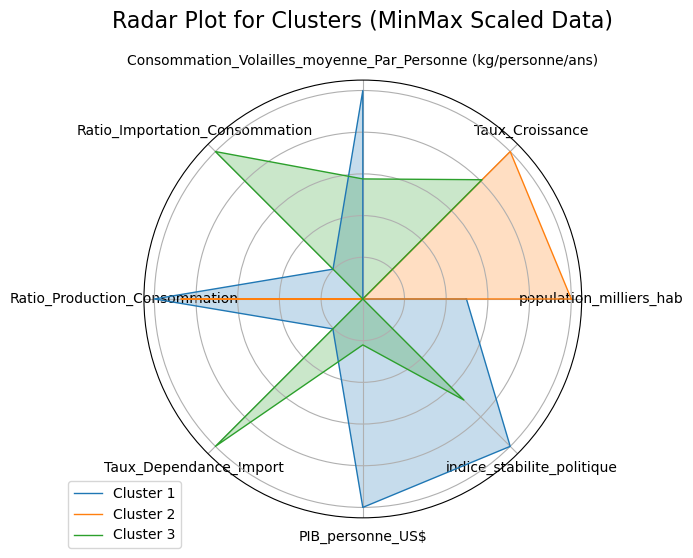

Traitement de la combinaison : Scaler = MinMaxScaler, Nombre de clusters = 4


C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


La liste des pays par cluster :
Cluster 1: ['Angola', 'Bénin', 'Botswana', 'Cabo Verde', 'Congo', 'Gabon', 'Gambie', 'Ghana', 'Guinée', 'Guinée-Bissau', 'Haïti', 'Iraq', 'Kazakhstan', 'Kirghizistan', 'Kiribati', 'Lesotho', 'Libéria', 'Mauritanie', 'Mongolie', 'Monténégro', 'Namibie', 'Oman', 'Sao Tomé-et-Principe', 'Tadjikistan', 'Vanuatu']
Cluster 2: ['Afrique du Sud', 'Algérie', 'Azerbaïdjan', 'Bangladesh', 'Belize', 'Bolivie (État plurinational de)', 'Brésil', 'Burkina Faso', 'Cambodge', 'Cameroun', 'Colombie', "Côte d'Ivoire", 'Égypte', 'El Salvador', 'Équateur', 'Eswatini', 'Éthiopie', 'Fédération de Russie', 'Guatemala', 'Honduras', 'Indonésie', "Iran (République islamique d')", 'Jordanie', 'Kenya', 'Liban', 'Madagascar', 'Malawi', 'Mali', 'Maroc', 'Mexique', 'Mozambique', 'Myanmar', 'Népal', 'Nicaragua', 'Niger', 'Nigéria', 'Ouganda', 'Pakistan', 'Paraguay', 'Philippines', 'République centrafricaine', 'République de Moldova', 'République populaire démocratique de Corée', 'Républ

,Cluster 1,Cluster 2,Cluster 3,Cluster 4
population_milliers_hab,"8,012.77","47,993.16","3,605.96","26,902.41"
Taux_Croissance,2.26,1.81,0.69,0.48
Consommation_Volailles_moyenne_Par_Personne (kg/personne/ans),11.13,12.20,36.17,29.67
Ratio_Importation_Consommation,97.96,9.87,103.64,28.20
Ratio_Production_Consommation,26.88,101.38,24.87,112.47
Taux_Dependance_Import,80.17,9.44,83.57,24.11
PIB_personne_US$,"3,595.97","3,381.90","14,368.38","26,079.62"
indice_stabilite_politique,-0.07,-0.76,0.39,0.55


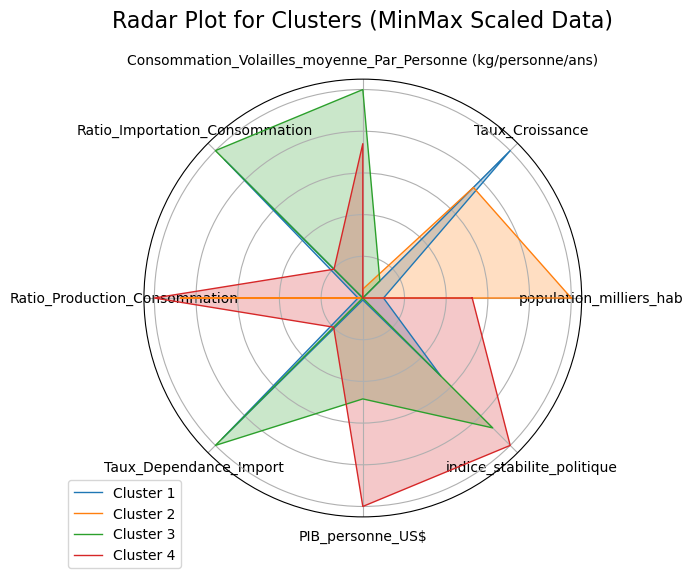

Traitement de la combinaison : Scaler = RobustScaler, Nombre de clusters = 4


C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


La liste des pays par cluster :
Cluster 1: ['Allemagne', 'Argentine', 'Australie', 'Autriche', 'Barbade', 'Bélarus', 'Bosnie-Herzégovine', 'Canada', 'Chili', 'Chine, Taiwan Province de', 'Chypre', 'Costa Rica', 'Croatie', 'Danemark', 'Espagne', 'Estonie', 'Fidji', 'Finlande', 'France', 'Grèce', 'Guyana', 'Hongrie', 'Irlande', 'Israël', 'Italie', 'Jamaïque', 'Lettonie', 'Lituanie', 'Malaisie', 'Malte', 'Maurice', 'Nouvelle-Zélande', 'Panama', 'Pologne', 'Portugal', 'République de Corée', 'République dominicaine', 'Roumanie', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Slovaquie', 'Slovénie', 'Suède', 'Tchéquie', 'Trinité-et-Tobago', 'Uruguay']
Cluster 2: ['Bangladesh', 'Brésil', "États-Unis d'Amérique", 'Fédération de Russie', 'Indonésie', 'Japon', 'Mexique', 'Nigéria', 'Pakistan']
Cluster 3: ['Albanie', 'Angola', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Arménie', 'Bahamas', 'Bénin', 'Botswana', 'Bulgarie', 'Cabo Verde', 'Congo', 'Cuba', 'Dominique', 'Gabon', 'Gambie', 'Géo

,Cluster 1,Cluster 2,Cluster 3,Cluster 4
population_milliers_hab,"16,898.00","194,871.62","6,307.68","30,544.10"
Taux_Croissance,0.45,1.19,1.67,1.85
Consommation_Volailles_moyenne_Par_Personne (kg/personne/ans),29.09,22.36,21.76,11.57
Ratio_Importation_Consommation,31.20,8.36,99.72,9.92
Ratio_Production_Consommation,110.24,107.80,25.27,101.35
Taux_Dependance_Import,26.62,6.84,81.25,9.47
PIB_personne_US$,"24,873.56","15,252.01","7,591.77","3,142.07"
indice_stabilite_politique,0.56,-0.74,0.10,-0.72


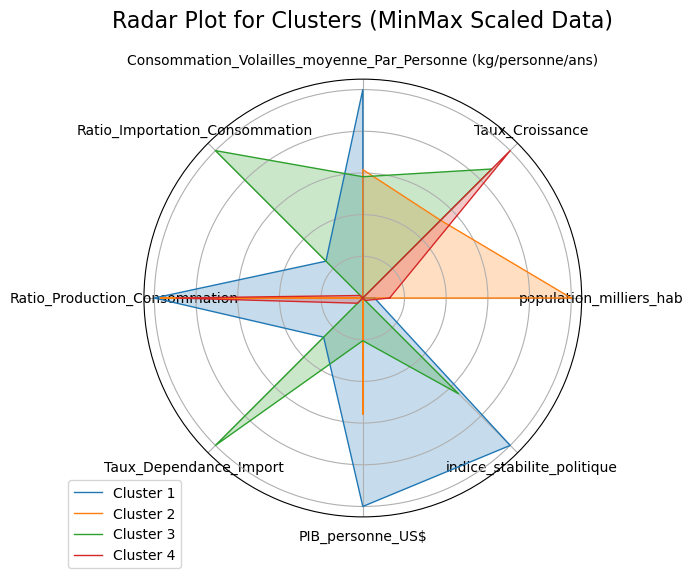

Traitement de la combinaison : Scaler = RobustScaler, Nombre de clusters = 9


C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


La liste des pays par cluster :
Cluster 1: ['Albanie', 'Angola', 'Arménie', 'Bénin', 'Cabo Verde', 'Congo', 'Gabon', 'Gambie', 'Géorgie', 'Ghana', 'Guinée', 'Guinée-Bissau', 'Haïti', 'Iraq', 'Kazakhstan', 'Kirghizistan', 'Kiribati', 'Lesotho', 'Libéria', 'Macédoine du Nord', 'Mauritanie', 'Mongolie', 'Monténégro', 'Namibie', 'Sao Tomé-et-Principe', 'Suriname', 'Tadjikistan', 'Vanuatu']
Cluster 2: ['Azerbaïdjan', 'Belize', 'Bolivie (État plurinational de)', 'Botswana', 'Burkina Faso', 'Cambodge', 'El Salvador', 'Équateur', 'Eswatini', 'Guatemala', 'Honduras', 'Jordanie', 'Liban', 'Madagascar', 'Malawi', 'Nicaragua', 'Niger', 'Paraguay', 'République centrafricaine', 'République de Moldova', 'Rwanda', 'Sénégal', 'Serbie', 'Sierra Leone', 'Sri Lanka', 'Tchad', 'Togo', 'Tunisie', 'Turkménistan', 'Zambie', 'Zimbabwe']
Cluster 3: ['Bangladesh', 'Égypte', 'Éthiopie', 'Fédération de Russie', "Iran (République islamique d')", 'Mexique', 'Philippines', 'Turquie', 'Viet Nam']
Cluster 4: ['Argentin

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9
population_milliers_hab,"7,354.94","11,247.19","110,488.81","9,514.82","12,109.37","71,449.81","39,747.86","3,945.82","239,269.80"
Taux_Croissance,1.80,2.00,1.44,0.24,1.00,0.42,1.68,1.41,1.61
Consommation_Volailles_moyenne_Par_Personne (kg/personne/ans),12.56,10.66,16.94,28.88,33.02,22.68,11.26,43.12,23.55
Ratio_Importation_Consommation,97.18,14.99,9.72,30.83,34.50,29.61,4.98,113.32,0.19
Ratio_Production_Consommation,26.65,97.10,96.44,113.86,106.99,101.55,105.58,14.78,118.73
Taux_Dependance_Import,80.73,14.32,9.40,25.08,32.35,25.89,4.68,88.39,0.18
PIB_personne_US$,"3,192.49","3,116.63","5,240.46","13,880.54","51,650.91","36,726.45","2,888.08","18,381.11","15,259.21"
indice_stabilite_politique,-0.15,-0.41,-1.05,0.47,0.85,0.48,-0.98,0.61,-1.02


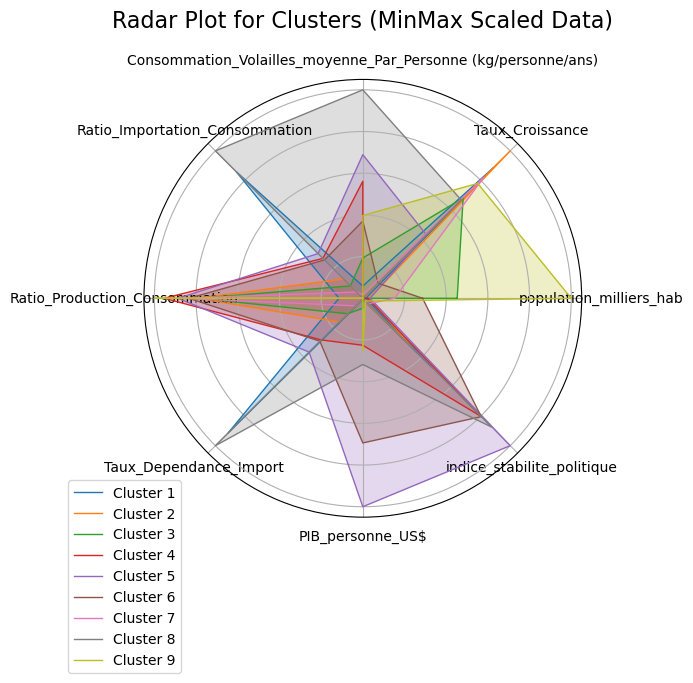

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans

# Message explicatif
print("Cette fonction résume les résulats des différents combinaisons de scalers et de nombres de clusters choisis.")
print("Les scalers utilisés sont : StandardScaler, MinMaxScaler, et RobustScaler.")
print("\nLa fonction affiche les centroides des clusters, crée des radar plots pour visualiser les centroides et affiche les listes des pays pour chaque cluster.")

# Résumer les combinaisons sous forme de tableau
summary_data = {
    'Scaler': ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'RobustScaler'],
    'Nombre de Clusters': [3, 4, 4, 9]
}
summary_df = pd.DataFrame(summary_data)
print("\nTableau des combinaisons retenues :")
print(summary_df)

def create_report_minmax_radar(df, scaler_type, n_clusters, zone_column):
    # Afficher la combinaison en cours de traitement
    print(f"Traitement de la combinaison : Scaler = {scaler_type}, Nombre de clusters = {n_clusters}")

    # Sélection des colonnes numériques
    numeric_cols = df.select_dtypes(include=np.number).columns
    df_numeric = df[numeric_cols]

    # Application du scaler
    if scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        scaler = MinMaxScaler()
    elif scaler_type == 'RobustScaler':
        scaler = RobustScaler()
    else:
        raise ValueError("Scaler non supporté. Utilisez 'StandardScaler', 'MinMaxScaler' ou 'RobustScaler'.")

    scaled_data = scaler.fit_transform(df_numeric)

    # Effectuer le clustering
    clustering = KMeans(n_clusters=n_clusters, n_init='auto', init='random', random_state=0)
    clustering.fit(scaled_data)

    # Créer une liste contenant les indicateurs avant d'ajouter les étiquettes de cluster
    indicateurs = df_numeric.columns.to_numpy()

    # Récupérer les étiquettes de cluster et les ajuster pour commencer à partir de 1
    labels = clustering.labels_ + 1

    # Ajouter les étiquettes de cluster au DataFrame d'origine : On associe nos groupes au DataFrame initial.
    df['Cluster'] = labels

    # Résultat 1 : Afficher les pays par cluster 
    # Afficher les pays qui composent chaque groupe
    print('La liste des pays par cluster :')
    countries_by_cluster = df.groupby('Cluster')[zone_column].apply(list)
    for cluster, countries in countries_by_cluster.items():
        print(f"\033[1mCluster {cluster}:\033[0m {countries}")

    # Résultat 2 : Afficher les centroids des indicateurs (valeurs réelles non normalisées)
    # Créer un DataFrame à partir des centroids avec les données non normalisées
    kmeans_clusters_statistics = pd.DataFrame(scaler.inverse_transform(clustering.cluster_centers_))

    # Définit les indicateurs comme index
    kmeans_clusters_statistics = kmeans_clusters_statistics.T
    kmeans_clusters_statistics.columns = [f'Cluster {i+1}' for i in range(n_clusters)]
    kmeans_clusters_statistics.index = indicateurs

    # Exclure la ligne 'Cluster' des indicateurs si elle existe
    if 'Cluster' in kmeans_clusters_statistics.index:
        kmeans_clusters_statistics = kmeans_clusters_statistics.drop('Cluster')

    # Ajuster les options d'affichage pour éviter le wrapping
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_rows', None)

    # Affiche le DataFrame avec réduction de la largeur des colonnes
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        print("\nCentroids des indicateurs (valeurs réelles non normalisées):")
        display(kmeans_clusters_statistics)

    # Résultat 3 : Tracer le radar plot avec MinMaxScaler appliqué
    minmax_scaler = MinMaxScaler()
    normalized_centroids = minmax_scaler.fit_transform(clustering.cluster_centers_)
    normalized_centroids = pd.DataFrame(normalized_centroids, columns=indicateurs)
    
    # Exclure la colonne 'Cluster' si elle existe
    if 'Cluster' in normalized_centroids.columns:
        normalized_centroids = normalized_centroids.drop('Cluster', axis=1)
    
    normalized_centroids.index = [f'Cluster {i+1}' for i in range(n_clusters)]

    # Tracer le radar plot pour les centroids des clusters avec les données normalisées
    num_vars = len(normalized_centroids.columns)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    for i in range(n_clusters):
        values = normalized_centroids.iloc[i].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i+1}')
        ax.fill(angles, values, alpha=0.25)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(normalized_centroids.columns, fontsize=10)
    ax.set_title('Radar Plot for Clusters (MinMax Scaled Data)', size=16, color='black', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.tight_layout()
    plt.show()

# Exemple d'appel de la fonction
results_Standard_3 = create_report_minmax_radar(df_final, 'StandardScaler', 3, 'Zone')
results_MinMax_4 = create_report_minmax_radar(df_final, 'MinMaxScaler', 4, 'Zone')
results_Robust_4 = create_report_minmax_radar(df_final, 'RobustScaler', 4, 'Zone')
results_Robust_9 = create_report_minmax_radar(df_final, 'RobustScaler', 9, 'Zone')


 Nous allons retenir les clusters 1 (minmax), 5 (robust), 3 (robust) et 3 (Standard) qui présentent une majorité d'indicateurs favorables (PIB élevé, stabilité politique, consommation de poulet). Nous allons les visualiser plus en détail dans des boxplots.

C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hicha\AppData\Local\Temp\ipykernel_203608\3523083950.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['Selected_Cluster'] = f'{scaler_type}_Cluster_{cluster_number}'
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  war

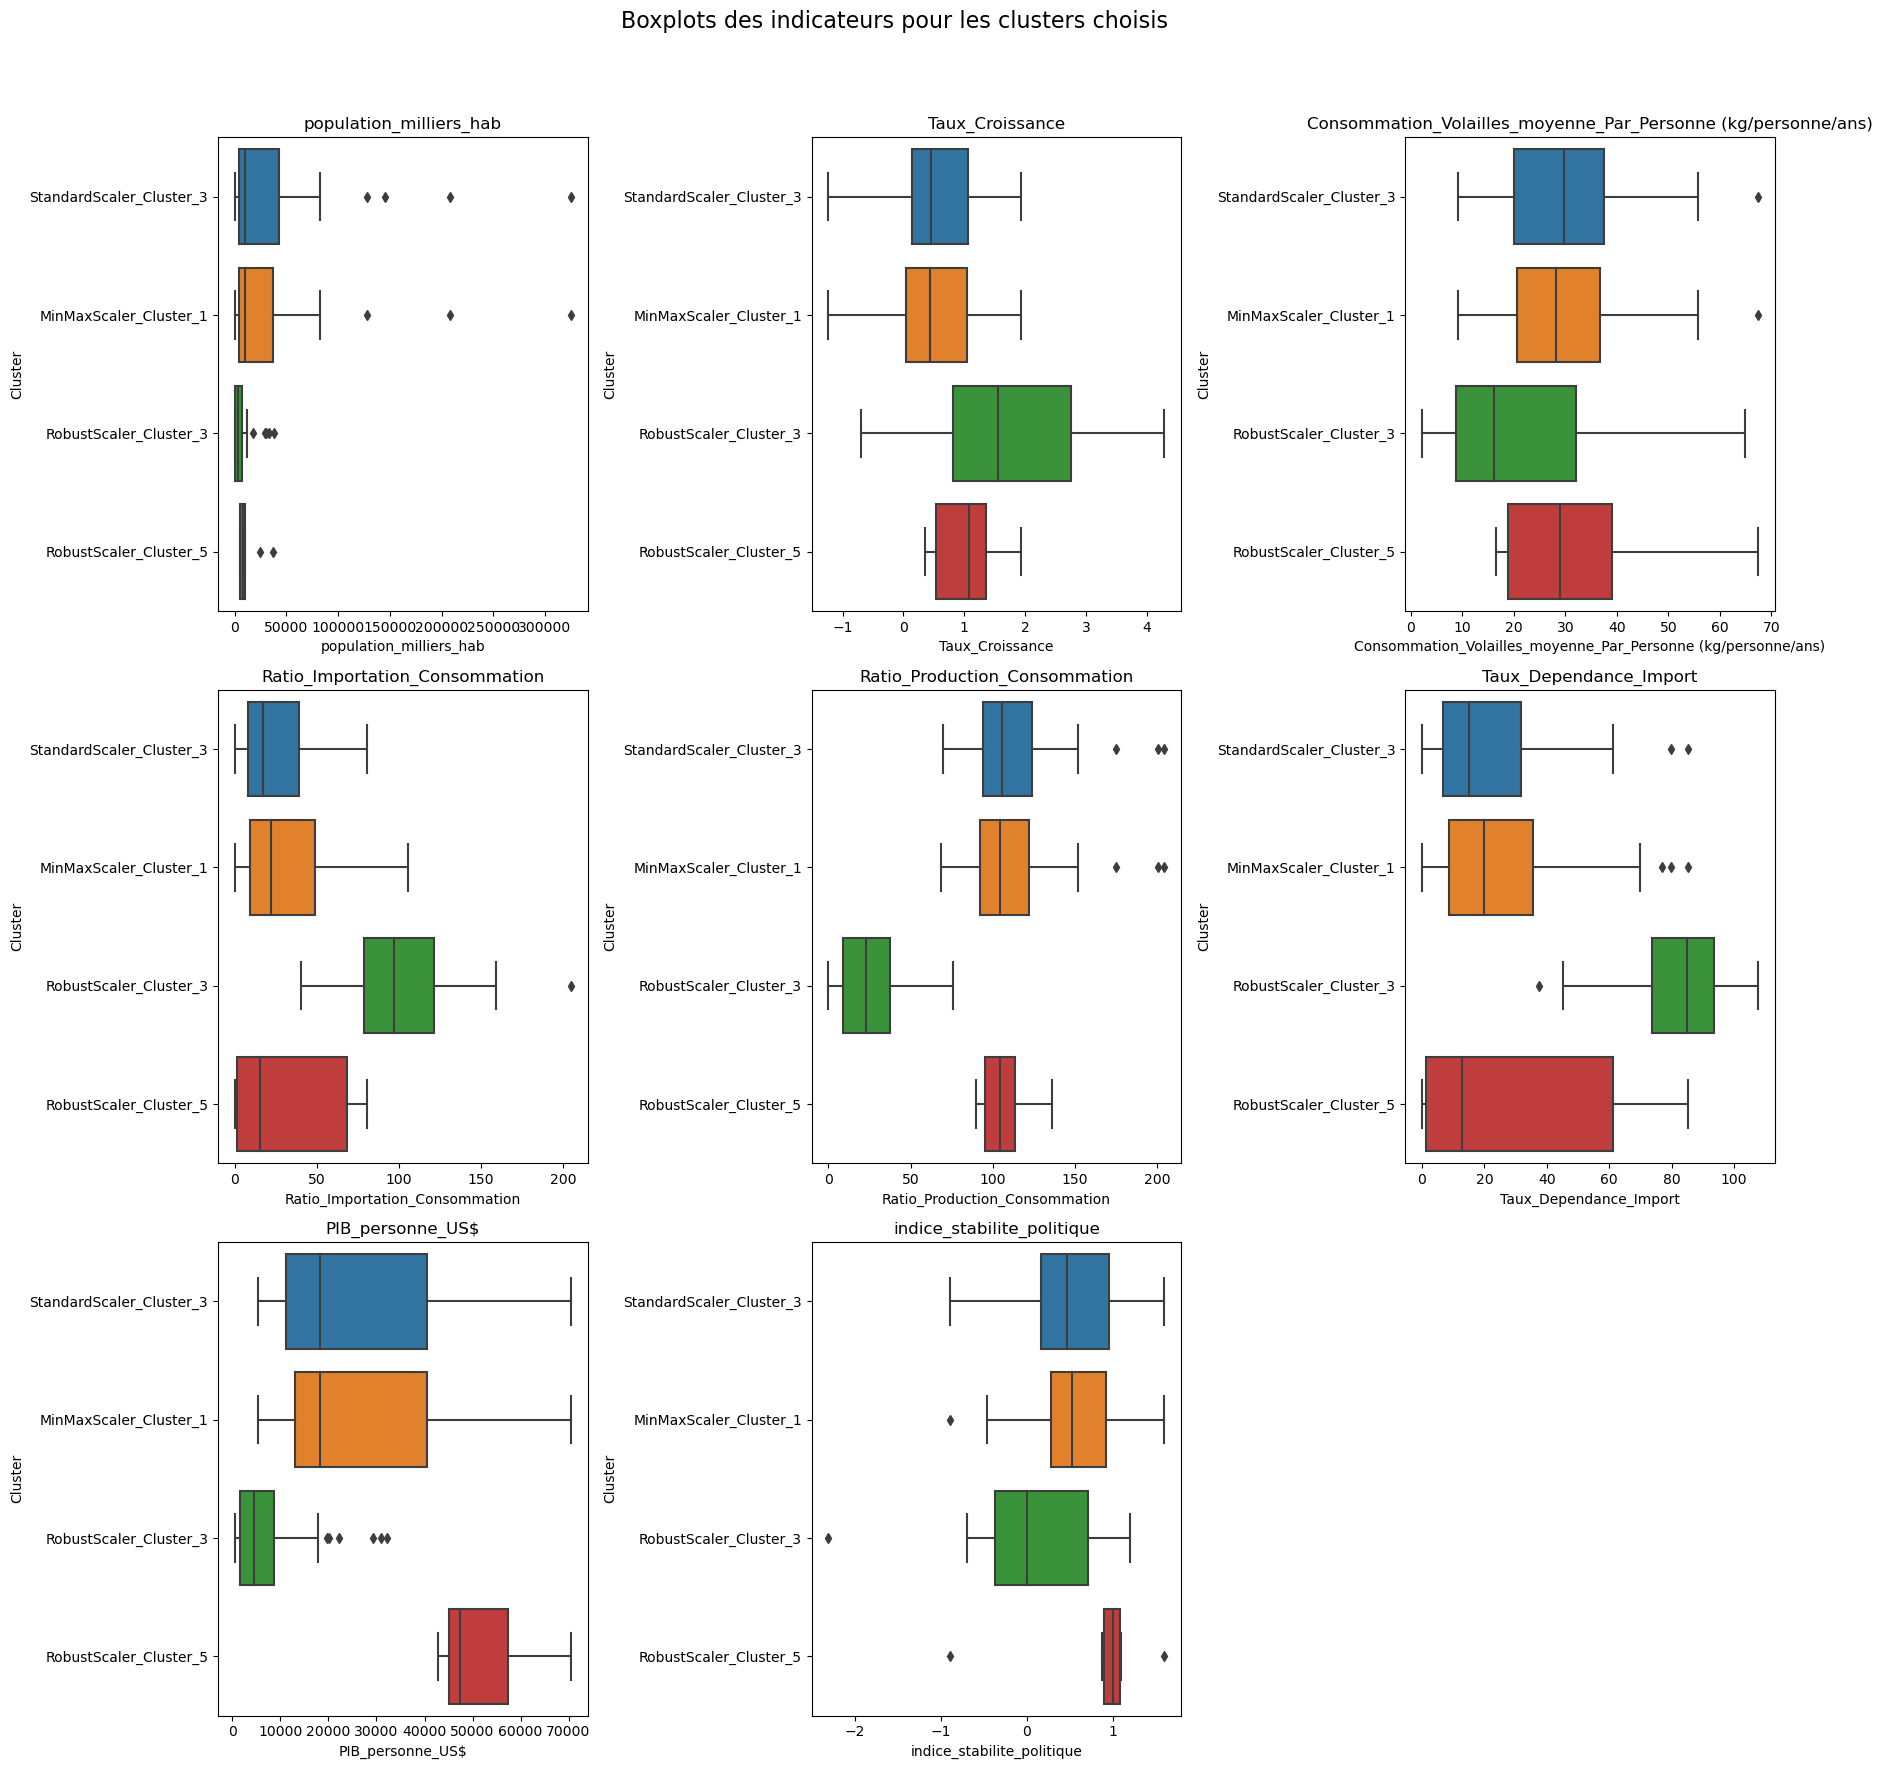

In [9]:

def plot_selected_clusters_boxplots(df, cluster_indices, indicateurs):
    """
    Tracer les boxplots pour les indicateurs spécifiés avec les clusters sélectionnés.
    """
    
    # Filtrer les données pour les clusters choisis
    selected_data = pd.DataFrame()
    
    for (scaler_type, n_clusters, cluster_number) in cluster_indices:
        # Appliquer le scaler et le clustering
        df_copy = df.copy()
        numeric_cols = df_copy.select_dtypes(include=np.number).columns
        df_numeric = df_copy[numeric_cols]

        if scaler_type == 'StandardScaler':
            scaler = StandardScaler()
        elif scaler_type == 'MinMaxScaler':
            scaler = MinMaxScaler()
        elif scaler_type == 'RobustScaler':
            scaler = RobustScaler()
        else:
            raise ValueError("Scaler non supporté. Utilisez 'StandardScaler', 'MinMaxScaler' ou 'RobustScaler'.")

        scaled_data = scaler.fit_transform(df_numeric)

        clustering = KMeans(n_clusters=n_clusters, n_init='auto', init='random', random_state=0)
        clustering.fit(scaled_data)

        labels = clustering.labels_ + 1
        df_copy['Cluster'] = labels
        
        # Filtrer les données pour le cluster spécifique
        cluster_data = df_copy[df_copy['Cluster'] == cluster_number]
        cluster_data['Selected_Cluster'] = f'{scaler_type}_Cluster_{cluster_number}'
        selected_data = pd.concat([selected_data, cluster_data], axis=0)
    
    # Exclure l'indicateur 'Cluster' et ne prendre que les 8 premiers
    indicateurs = [ind for ind in indicateurs if ind != 'Cluster'][:8]
    
    # Créer les boxplots
    num_indicators = len(indicateurs)
    num_cols = 3
    num_rows = (num_indicators + num_cols - 1) // num_cols  # Calculer le nombre de lignes nécessaires
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 6 * num_rows), sharey=False)
    fig.suptitle(f"Boxplots des indicateurs pour les clusters choisis", size=16)
    
    # Aplatir les axes pour une itération facile
    axes = axes.flatten()
    
    for ax, col in zip(axes, indicateurs):
        sns.boxplot(y='Selected_Cluster', x=col, data=selected_data, ax=ax)
        ax.set_title(col)
        ax.set_ylabel('Cluster')
        ax.set_xlabel(col)
    
    # Supprimer les axes vides si nécessaire
    for i in range(len(indicateurs), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Détails des clusters choisis 
cluster_indices = [
    ('StandardScaler', 3, 3),  # Cluster 3 pour StandardScaler avec 3 clusters
    ('MinMaxScaler', 4, 1),    # Cluster 1 pour MinMaxScaler avec 4 clusters
    ('RobustScaler', 4, 3),    # Cluster 3 pour RobustScaler avec 4 clusters
    ('RobustScaler', 9, 5)     # Cluster 5 pour RobustScaler avec 9 clusters
]

# Indicateurs à tracer
indicateurs = df_final.select_dtypes(include=np.number).columns.tolist()

# Appel de la fonction pour tracer les boxplots pour les indicateurs choisis
plot_selected_clusters_boxplots(df_final, cluster_indices, indicateurs)


Les groupes 1(MinnMax) et 5  (Robust) ont une plus forte dependance au importation de poulet et un PIB trés élevé respectivement. Cependant les groupe 3 (Robust) et 3 (Standard) ont a un PIB faible que ceux des autres groupes.

En conclusion de cette deuxième méthode de clustering, on retient les pays des groupes 5 et 1 que nous allons sauvegarder dans une liste pour la comparer avec le résultat des autres méthodes de classification.

In [10]:
# Groupes choisis aprés avoir alayser les boxplot
selected_groups = [5, 1] # RobustScaler et MinMax respectivement

# Filtrer les données pour les clusters choisis
selected_countries = []
for group in selected_groups:
    # Filtrer les pays pour le groupe spécifique
    countries = df_final[df_final['Cluster'] == group]['Zone'].tolist()
    selected_countries.extend(countries)

# Afficher les pays sélectionnés
print("Pays à viser par votre entreprise de poulet :")
print(selected_countries)



Pays à viser par votre entreprise de poulet :
['Australie', 'Autriche', 'Canada', 'Danemark', 'Finlande', 'Irlande', 'Israël', 'Nouvelle-Zélande', 'Suède', 'Albanie', 'Angola', 'Arménie', 'Bénin', 'Cabo Verde', 'Congo', 'Gabon', 'Gambie', 'Géorgie', 'Ghana', 'Guinée', 'Guinée-Bissau', 'Haïti', 'Iraq', 'Kazakhstan', 'Kirghizistan', 'Kiribati', 'Lesotho', 'Libéria', 'Macédoine du Nord', 'Mauritanie', 'Mongolie', 'Monténégro', 'Namibie', 'Sao Tomé-et-Principe', 'Suriname', 'Tadjikistan', 'Vanuatu']


## Classification Ascendante Hiérarchique (CAH)


La deuxième méthode que nous allons utiliser est la classification ascendante hiérarchique qui consiste à regrouper, de manière itérative, les individus (ici les pays), à partir de la « distance » qui les sépare. Les distances entre individus sont regroupées dans une matrice calculée à partir des données initiales.

Pour ce faire nous allons suivre la même démarche qu'avant ( de la méthode des kmeans) :
 
**Etape 1 :** 

Réalisation de la CAH : : Tester plusieurs scalers, tracer les dendogrammes. On cherche ensuite la distance (en ordonnée) à laquelle couper le dendrogramme de manière à former les clusters. Cependant, le choix de la distance par lecture visuelle est subjective, d'autant plus avec le nombre d'individus présents dans nos données.

Pour choisir un nombre de clusters de manière plus objective, nous allons nous appuyer sur le coefficient de Silhouette qui rend compte de la qualité d'un regroupement. Il mesure à quel point les individus d'un même groupe sont similaires entre eux par rapport aux objets des autres groupes. Donc, cette étape évalue le nombre optimal de clusters en découpant le dendrogramme à différents niveaux (c'est-à-dire pour différents nombres de clusters) et en calculant le score de silhouette pour chaque découpe. Le score de silhouette moyen est ensuite tracé pour visualiser la qualité du clustering en fonction du nombre de clusters.
C'est-à-dire vers la fin e cette étape on peut choisir les meuilleures combinaisons ( Scaler, nombre de clusters)

**Etape 2  :**

Appel de la fonction create_repport pour afficher les trois résultats 1 ( pays par clusters, centroides des indicateurs, les radard plot), puis choisir les meuilleurs groupes de pays à viser par notre entreprise.

**Etape 3  :**

Comparaison des résultats CAH et kmeans.


Processing with StandardScaler


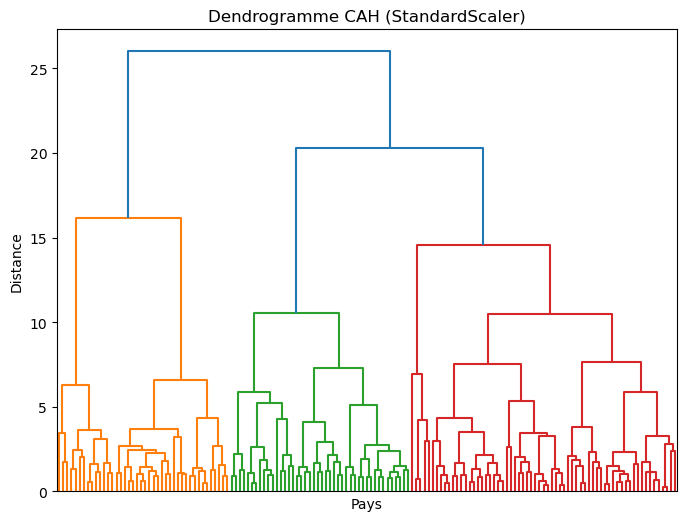

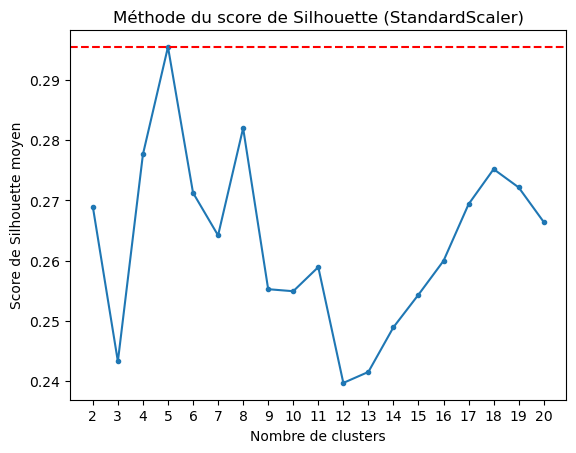

Processing with MinMaxScaler


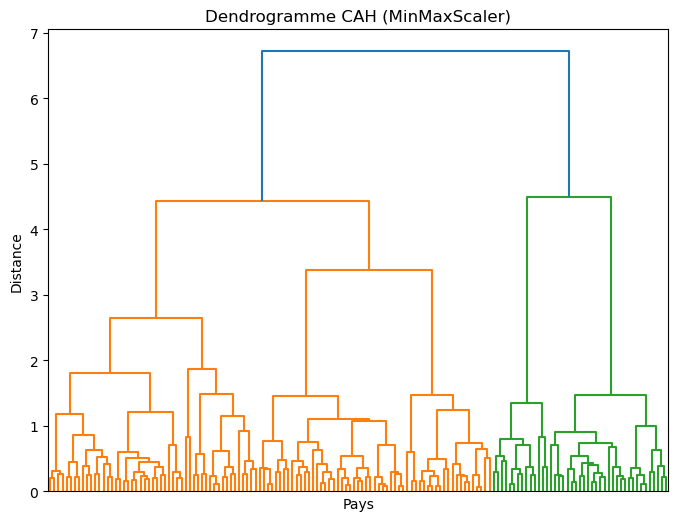

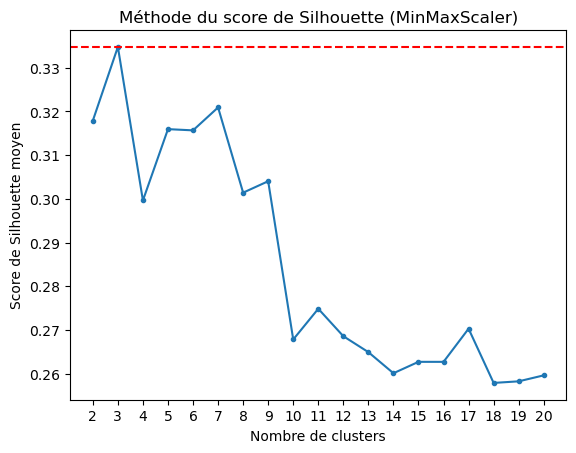

Processing with RobustScaler


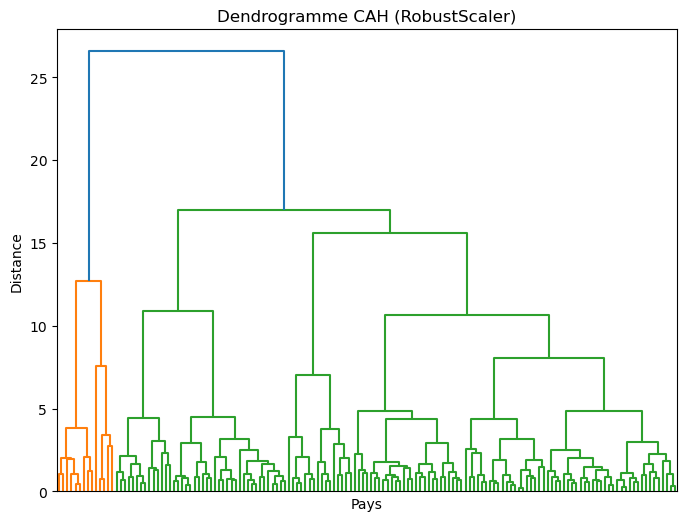

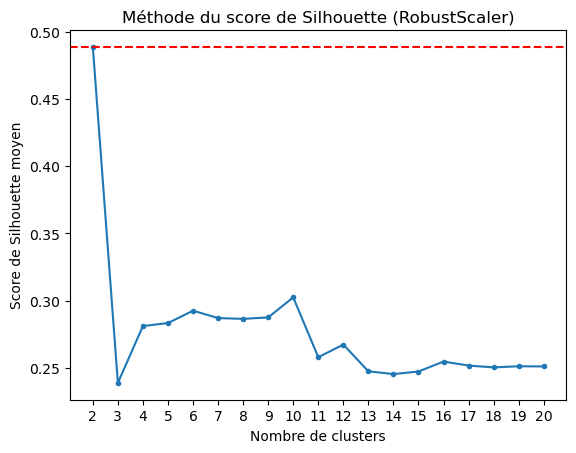

In [11]:
# Etape 1 (CAH) : tester plusieurs scalers, afficher les dendogramme et appliquer la méthode du score silhouette

# Sélection des colonnes numériques
numeric_cols = df_final.select_dtypes(include=np.number).columns
df_numeric = df_final[numeric_cols]

# Liste des scalers à tester
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Initialisation du nombre de clusters à tester
n_clusters_range = range(2, 21)

# Boucle sur chaque scaler
for scaler_name, scaler in scalers.items():
    print(f"Processing with {scaler_name}")

    # Normalisation des données
    scaled_data = scaler.fit_transform(df_numeric)

    # Clustering hiérarchique: création d'une Matrice des liens selon la Méthode de Ward
    Z = linkage(scaled_data, method='ward', metric='euclidean')

    # Trace le dendogramme
    fig, ax = plt.subplots(figsize=(8, 6))
    dn = dendrogram(Z, no_labels=True, orientation='top', ax=ax)
    ax.set_title(f'Dendrogramme CAH ({scaler_name})')
    ax.set_xlabel('Pays')
    ax.set_ylabel('Distance')
    plt.show()

    #Évaluation du Nombre Optimal de Clusters : Calcule le score de Silhouette moyen pour chaque valeur du nombre de clusters
    silhouette_avg_scores = []
    for n_clusters in n_clusters_range:
        clustering = fcluster(Z, t=n_clusters, criterion='maxclust')
        silhouette_avg = silhouette_score(scaled_data, clustering)
        silhouette_avg_scores.append(silhouette_avg)

    # Trace le graphique du score de silhouette
    fig, ax = plt.subplots()
    plt.plot(n_clusters_range, silhouette_avg_scores, marker='.')
    plt.axhline(y=max(silhouette_avg_scores), linestyle='--', color='r')
    ax.xaxis.set_major_locator(ticker.IndexLocator(1, 0))
    ax.set_xlabel('Nombre de clusters')
    ax.set_ylabel('Score de Silhouette moyen')
    ax.set_title(f'Méthode du score de Silhouette ({scaler_name})')
    plt.show()


La méthode du score de Silhouette nous indique le nombre optimal de clusters pour le StandardScaler est 5. Par contre pour le MinMaxScaler la méthode montre que c'est 2 clusters. Néanmoins, cela est trop peu par rapport au nombre de pays à grouper. On choisit donc la deuxième meilleure valeur qui est de 7. Derniérement pour le RobustScaler on prend 5 clusters.

Cette fonction résume les résultats des différentes combinaisons de scalers et de nombres de clusters choisis.
Les scalers utilisés sont : StandardScaler, MinMaxScaler, et RobustScaler.

La fonction affiche les centroids des clusters, crée des radar plots pour visualiser les centroids et affiche les listes des pays pour chaque cluster.

Tableau des combinaisons retenues :
           Scaler  Nombre de Clusters
0  StandardScaler                   5
1    MinMaxScaler                   7
2    RobustScaler                   5
Traitement de la combinaison : Scaler = StandardScaler, Nombre de clusters = 5
La liste des pays par cluster :
Cluster 1: ['Antigua-et-Barbuda', 'Arabie saoudite', 'Bahamas', 'Cuba', 'Dominique', 'Grenade', 'Koweït', 'Malte', 'Nouvelle-Calédonie', 'Oman', 'Polynésie française', 'Sainte-Lucie', 'Saint-Kitts-et-Nevis', 'Samoa']
Cluster 2: ['Albanie', 'Angola', 'Arménie', 'Bénin', 'Botswana', 'Cabo Verde', 'Congo', 'Gabon', 'Gambie', 'Géorgie', 'Ghana', 'Guinée', 'Guinée-

,population_milliers_hab,Taux_Croissance,Consommation_Volailles_moyenne_Par_Personne (kg/personne/ans),Ratio_Importation_Consommation,Ratio_Production_Consommation,Taux_Dependance_Import,PIB_personne_US$,indice_stabilite_politique
Cluster,,,,,,,,
1,3945.822071,1.413461,43.116429,113.315142,14.782758,88.388571,18381.107471,0.613352
2,6092.525036,1.768049,12.149286,95.619197,28.426330,79.105000,3263.209658,-0.029286
3,19808.453250,0.461993,29.235682,31.507598,110.854460,26.767955,25509.897553,0.580874
4,239269.799000,1.611271,23.554000,0.185259,118.732129,0.180000,15259.210600,-1.018000
5,35281.279433,1.747876,12.219000,12.361765,99.010733,11.756500,3495.146768,-0.725833


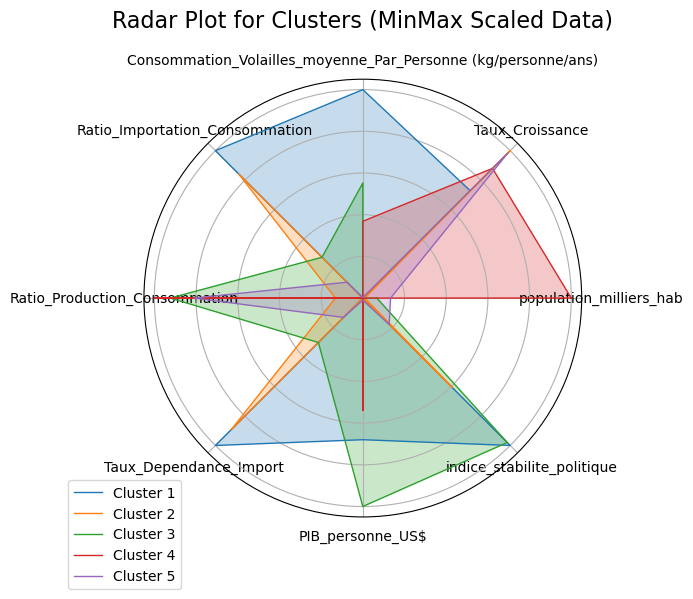

Traitement de la combinaison : Scaler = MinMaxScaler, Nombre de clusters = 7
La liste des pays par cluster :
Cluster 1: ['Antigua-et-Barbuda', 'Arabie saoudite', 'Bahamas', 'Cuba', 'Dominique', 'Grenade', 'Koweït', 'Malte', 'Nouvelle-Calédonie', 'Polynésie française', 'Sainte-Lucie', 'Saint-Kitts-et-Nevis', 'Samoa']
Cluster 2: ['Angola', 'Bénin', 'Cabo Verde', 'Congo', 'Gabon', 'Gambie', 'Ghana', 'Guinée', 'Guinée-Bissau', 'Haïti', 'Kirghizistan', 'Libéria', 'Mauritanie', 'Mongolie', 'Namibie', 'Oman', 'Sao Tomé-et-Principe', 'Tadjikistan', 'Vanuatu']
Cluster 3: ['Albanie', 'Arménie', 'Botswana', 'Bulgarie', 'Estonie', 'Géorgie', 'Kazakhstan', 'Kiribati', 'Lesotho', 'Lettonie', 'Macédoine du Nord', 'Monténégro', 'Slovaquie', 'Suriname']
Cluster 4: ['Afrique du Sud', 'Algérie', 'Azerbaïdjan', 'Belize', 'Bolivie (État plurinational de)', 'Bosnie-Herzégovine', 'Cambodge', 'Colombie', 'El Salvador', 'Équateur', 'Eswatini', 'Fédération de Russie', 'Honduras', "Iran (République islamique d')

,population_milliers_hab,Taux_Croissance,Consommation_Volailles_moyenne_Par_Personne (kg/personne/ans),Ratio_Importation_Consommation,Ratio_Production_Consommation,Taux_Dependance_Import,PIB_personne_US$,indice_stabilite_politique
Cluster,,,,,,,,
1,3890.429308,1.192298,44.769231,112.428123,15.386362,86.903846,18425.612018,0.602840
2,7349.900368,2.497224,10.514737,108.085788,22.921027,85.656316,3108.231245,-0.053684
3,3673.525214,0.301604,17.152857,77.217468,48.692184,69.222857,7998.009009,0.235714
4,32839.691125,0.973389,17.413438,10.628202,104.790912,9.865312,4695.506149,-0.472500
5,55788.292452,2.578600,6.128065,12.961941,94.118259,12.577419,2154.591883,-1.075484
6,15001.321852,0.448763,30.305185,21.299477,118.865965,17.301111,15964.673679,0.486980
7,65575.600067,0.811948,32.915333,31.964494,107.815176,29.160000,46565.967730,0.658667


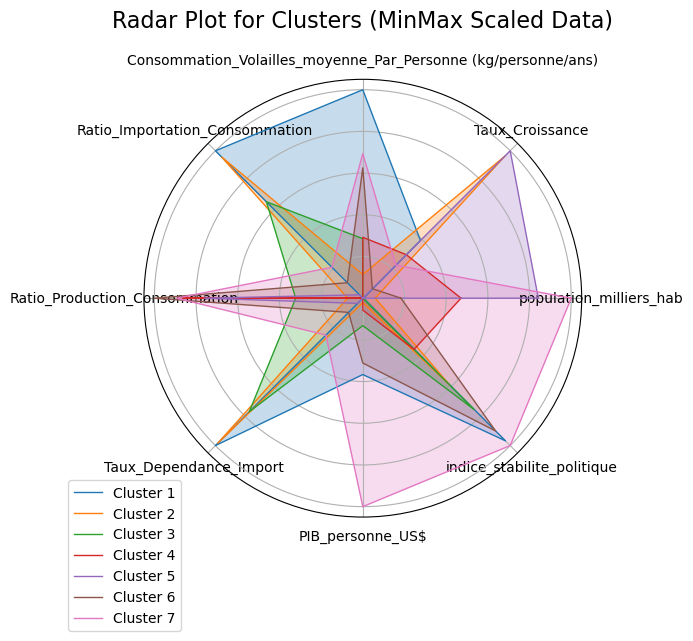

Traitement de la combinaison : Scaler = RobustScaler, Nombre de clusters = 5
La liste des pays par cluster :
Cluster 1: ['Bangladesh', 'Brésil', "États-Unis d'Amérique", 'Indonésie', 'Nigéria', 'Pakistan']
Cluster 2: ['Albanie', 'Angola', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Arménie', 'Bahamas', 'Bénin', 'Botswana', 'Bulgarie', 'Cabo Verde', 'Congo', 'Cuba', 'Dominique', 'Estonie', 'Gabon', 'Gambie', 'Géorgie', 'Ghana', 'Grenade', 'Guinée', 'Guinée-Bissau', 'Haïti', 'Iraq', 'Kazakhstan', 'Kirghizistan', 'Kiribati', 'Koweït', 'Lesotho', 'Lettonie', 'Libéria', 'Macédoine du Nord', 'Malte', 'Mauritanie', 'Mongolie', 'Monténégro', 'Namibie', 'Nouvelle-Calédonie', 'Oman', 'Polynésie française', 'Sainte-Lucie', 'Saint-Kitts-et-Nevis', 'Samoa', 'Sao Tomé-et-Principe', 'Slovaquie', 'Suriname', 'Tadjikistan', 'Vanuatu']
Cluster 3: ['Allemagne', 'Australie', 'Autriche', 'Canada', 'Danemark', 'Espagne', 'Finlande', 'France', 'Irlande', 'Israël', 'Italie', 'Japon', 'Nouvelle-Zélande', 'Républ

,population_milliers_hab,Taux_Croissance,Consommation_Volailles_moyenne_Par_Personne (kg/personne/ans),Ratio_Importation_Consommation,Ratio_Production_Consommation,Taux_Dependance_Import,PIB_personne_US$,indice_stabilite_politique
Cluster,,,,,,,,
1,226005.736500,1.561171,19.878333,0.154383,116.269172,0.150000,13013.669317,-1.058333
2,5940.549404,1.488102,22.061064,99.573559,28.389627,81.050638,8835.886583,0.166105
3,38070.810375,0.742906,28.499375,32.358851,104.610545,29.520000,45121.459849,0.690000
4,88602.146250,1.300935,21.829167,9.843287,102.954026,9.503333,5524.474950,-0.925000
5,15757.585029,1.367784,17.243000,15.371020,106.766460,13.426000,6793.428345,-0.238736


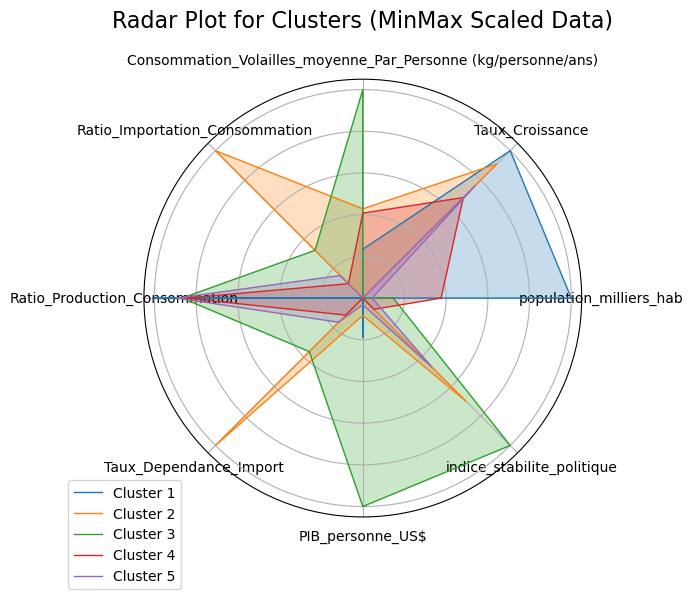

In [12]:
#Etape 2:  afficher les trois résultats : pays par clusters, centroides des indicateurs, les radard plot, 
#puis choisir les meuilleurs groupes de pays à viser par notre entreprise.

# Message explicatif
print("Cette fonction résume les résultats des différentes combinaisons de scalers et de nombres de clusters choisis.")
print("Les scalers utilisés sont : StandardScaler, MinMaxScaler, et RobustScaler.")
print("\nLa fonction affiche les centroids des clusters, crée des radar plots pour visualiser les centroids et affiche les listes des pays pour chaque cluster.")

# Résumer les combinaisons sous forme de tableau
summary_data = {
    'Scaler': ['StandardScaler', 'MinMaxScaler', 'RobustScaler'],
    'Nombre de Clusters': [5, 7, 5]
}
summary_df = pd.DataFrame(summary_data)
print("\nTableau des combinaisons retenues :")
print(summary_df)

def create_report_cah(df, scaler_type, n_clusters, zone_column):
    # Afficher la combinaison en cours de traitement
    print(f"Traitement de la combinaison : Scaler = {scaler_type}, Nombre de clusters = {n_clusters}")

    # Sélection des colonnes numériques
    numeric_cols = df.select_dtypes(include=np.number).columns
    df_numeric = df[numeric_cols]

    # Application du scaler
    if scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        scaler = MinMaxScaler()
    elif scaler_type == 'RobustScaler':
        scaler = RobustScaler()
    else:
        raise ValueError("Scaler non supporté. Utilisez 'StandardScaler', 'MinMaxScaler' ou 'RobustScaler'.")

    scaled_data = scaler.fit_transform(df_numeric)

    # Clustering hiérarchique: création d'une Matrice des liens selon la Méthode de Ward
    Z = linkage(scaled_data, method='ward', metric='euclidean')

    # Récupérer les étiquettes de cluster
    labels = fcluster(Z, t=n_clusters, criterion='maxclust')

    # Ajouter les étiquettes de cluster au DataFrame d'origine : On associe nos groupes au DataFrame initial.
    df['Cluster'] = labels

    # Résultat 1 : Afficher les pays par cluster 
    print('La liste des pays par cluster :')
    countries_by_cluster = df.groupby('Cluster')[zone_column].apply(list)
    for cluster, countries in countries_by_cluster.items():
        print(f"\033[1mCluster {cluster}:\033[0m {countries}")

    # Résultat 2 : Afficher les centroids des indicateurs (valeurs réelles non normalisées)
    centroids = df.groupby('Cluster')[numeric_cols].mean()
    
    # Exclure la colonne 'Cluster' si elle existe
    if 'Cluster' in centroids.columns:
        centroids = centroids.drop('Cluster', axis=1)

    # Affiche le DataFrame avec réduction de la largeur des colonnes
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_rows', None)
    
    print("\nCentroids des indicateurs (valeurs réelles non normalisées):")
    display(centroids)

    # Résultat 3 : Tracer le radar plot
    # Normaliser les centroids avec MinMaxScaler pour les afficher dans un radar plot
    minmax_scaler = MinMaxScaler()
    normalized_centroids = minmax_scaler.fit_transform(centroids)
    normalized_centroids = pd.DataFrame(normalized_centroids, columns=centroids.columns)
    
    # Exclure la colonne 'Cluster' si elle existe
    if 'Cluster' in normalized_centroids.columns:
        normalized_centroids = normalized_centroids.drop('Cluster', axis=1)
    
    normalized_centroids.index = [f'Cluster {i+1}' for i in range(n_clusters)]

    # Tracer le radar plot pour les centroids des clusters avec les données normalisées
    num_vars = len(normalized_centroids.columns)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    for i in range(n_clusters):
        values = normalized_centroids.iloc[i].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i+1}')
        ax.fill(angles, values, alpha=0.25)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(normalized_centroids.columns, fontsize=10)
    ax.set_title('Radar Plot for Clusters (MinMax Scaled Data)', size=16, color='black', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.tight_layout()
    plt.show()

# Exemple d'appel de la fonction
results_Standard_5 = create_report_cah(df_final, 'StandardScaler', 5, 'Zone')
results_MinMax_7 = create_report_cah(df_final, 'MinMaxScaler', 7, 'Zone')
results_Robust_5 = create_report_cah(df_final, 'RobustScaler', 5, 'Zone')


Les pays des cluster 3, 1 pour le StandardScaler et 2 pour MinMaxScaler ont une majorité d'indicateurs favorables par rapport au autres clusters ( PIB élevé, taux de dependance aux importations élevé, consommation moyenne de vollailes), ainsi que le cluster 3 pour le RobustScaler. Mais le groupe 1 pour StadardScaler est composé d'îles ce qui ne facilite pas la logistique.

Nous allons les visualiser plus en détail dans des boxplots.

C:\Users\hicha\AppData\Local\Temp\ipykernel_203608\2169786287.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['Selected_Cluster'] = f'{scaler_type}_Cluster_{cluster_number}'
C:\Users\hicha\AppData\Local\Temp\ipykernel_203608\2169786287.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['Selected_Cluster'] = f'{scaler_type}_Cluster_{cluster_number}'
C:\Users\hicha\AppData\Local\Temp\ipykernel_203608\2169786287.py:35: SettingWithCopyWarning: 
A value is trying to be set on a c

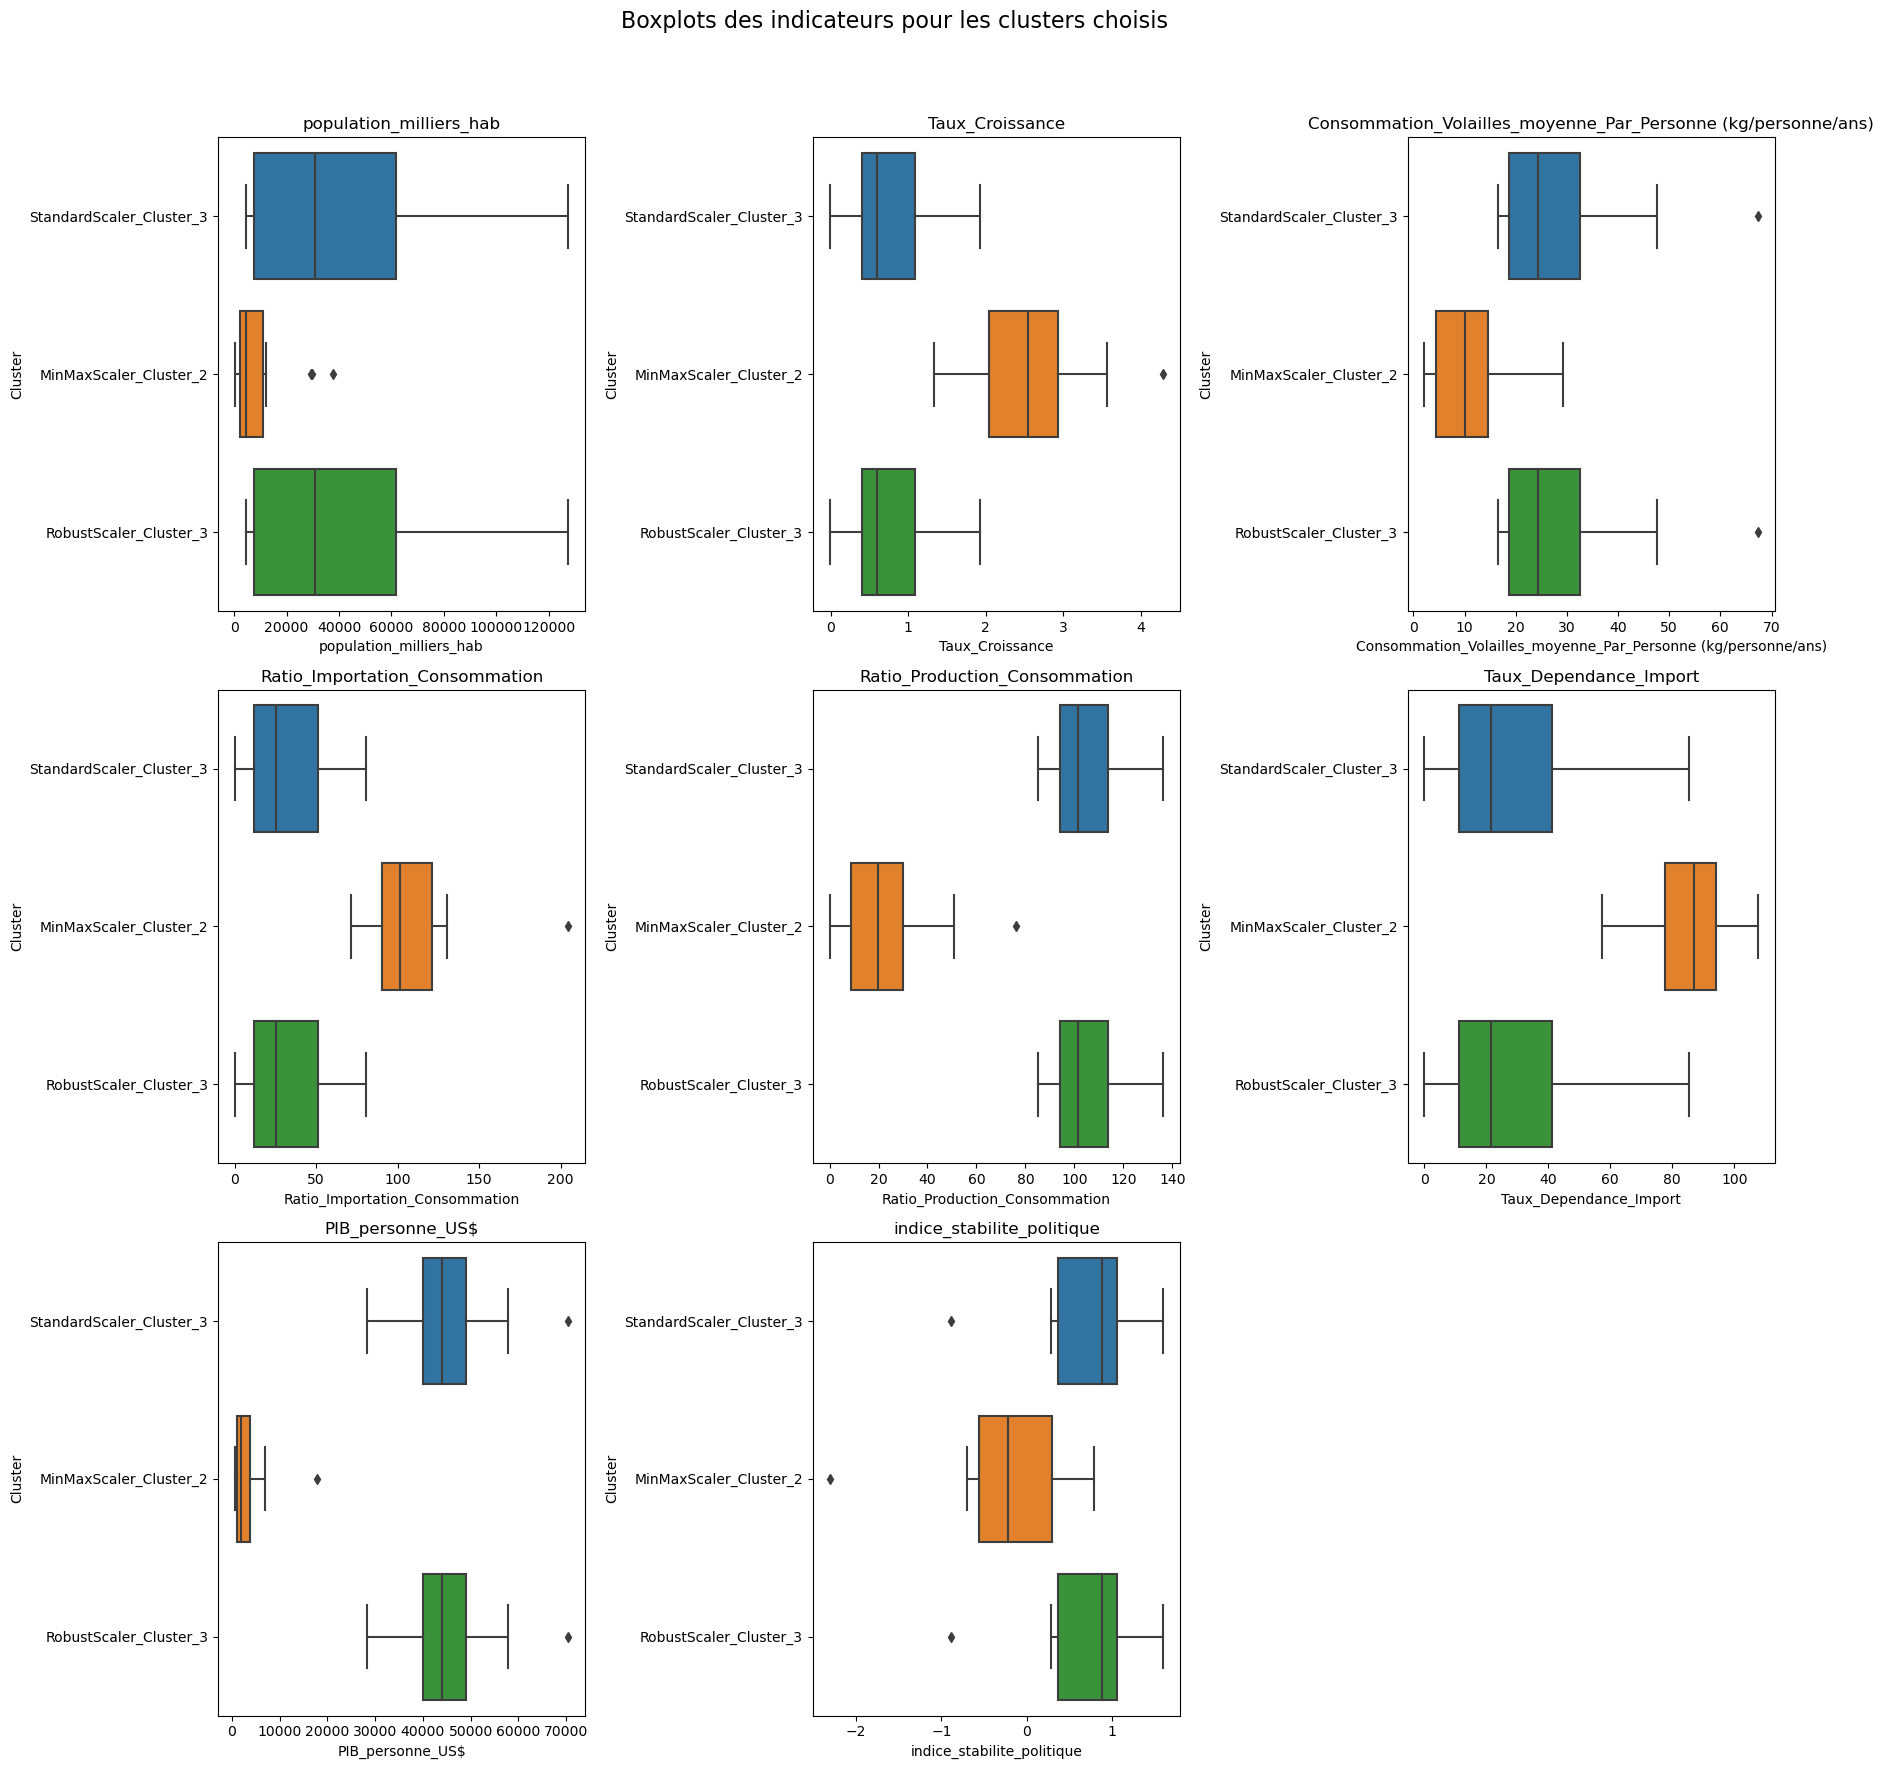

In [13]:
# Fonction pour tracer les boxplot
def plot_selected_clusters_boxplots_cah(df, cluster_indices, indicateurs):
    """
    Tracer les boxplots pour les indicateurs spécifiés avec les clusters sélectionnés.
    """
    
    # Filtrer les données pour les clusters choisis
    selected_data = pd.DataFrame()
    
    for (scaler_type, n_clusters, cluster_number) in cluster_indices:
        # Appliquer le scaler et le clustering hiérarchique
        df_copy = df.copy()
        numeric_cols = df_copy.select_dtypes(include=np.number).columns
        df_numeric = df_copy[numeric_cols]

        if scaler_type == 'StandardScaler':
            scaler = StandardScaler()
        elif scaler_type == 'MinMaxScaler':
            scaler = MinMaxScaler()
        elif scaler_type == 'RobustScaler':
            scaler = RobustScaler()
        else:
            raise ValueError("Scaler non supporté. Utilisez 'StandardScaler', 'MinMaxScaler' ou 'RobustScaler'.")

        scaled_data = scaler.fit_transform(df_numeric)

        # Clustering hiérarchique
        Z = linkage(scaled_data, method='ward', metric='euclidean')
        labels = fcluster(Z, t=n_clusters, criterion='maxclust')

        df_copy['Cluster'] = labels
        
        # Filtrer les données pour le cluster spécifique
        cluster_data = df_copy[df_copy['Cluster'] == cluster_number]
        cluster_data['Selected_Cluster'] = f'{scaler_type}_Cluster_{cluster_number}'
        selected_data = pd.concat([selected_data, cluster_data], axis=0)
    
    # Exclure l'indicateur 'Cluster' et ne prendre que les 8 premiers
    indicateurs = [ind for ind in indicateurs if ind != 'Cluster'][:8]
    
    # Créer les boxplots
    num_indicators = len(indicateurs)
    num_cols = 3
    num_rows = (num_indicators + num_cols - 1) // num_cols  # Calculer le nombre de lignes nécessaires
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 6 * num_rows), sharey=False)
    fig.suptitle(f"Boxplots des indicateurs pour les clusters choisis", size=16)
    
    # Aplatir les axes pour une itération facile
    axes = axes.flatten()
    
    for ax, col in zip(axes, indicateurs):
        sns.boxplot(y='Selected_Cluster', x=col, data=selected_data, ax=ax)
        ax.set_title(col)
        ax.set_ylabel('Cluster')
        ax.set_xlabel(col)
    
    # Supprimer les axes vides si nécessaire
    for i in range(len(indicateurs), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Détails des clusters choisis
cluster_indices = [
    ('StandardScaler', 5, 3),  # Cluster 3 pour StandardScaler avec 5 clusters
    ('MinMaxScaler', 7, 2),    # Cluster 2 pour MinMaxScaler avec 7 clusters
    ('RobustScaler', 5, 3)     # Cluster 3 pour RobustScaler avec 5 clusters
]

# Indicateurs à tracer
indicateurs = df_final.select_dtypes(include=np.number).columns.tolist()

# Appel de la fonction pour tracer les boxplots pour les indicateurs choisis
plot_selected_clusters_boxplots_cah(df_final, cluster_indices, indicateurs)


Les groupes 3(Robust) et 3 (StadardScaler) semblent les meuilleurs à viser. Il ont une plus forte dependance au importation de poulet, une bonne stabilité politique et un PIB élevé . Cependant le groupe 2 (MinMax) a un faible PIB et stabilité politique par rapport aux autres groupes.

En conclusion de cette deuxième méthode de clustering, on retient les pays des groupes 3( pour les deux scalers StandarScaler et Robust) que nous allons sauvegarder dans une liste pour la comparer avec le résultat de la précédente méthode ' kmeans'

In [14]:
# Groupes choisis
selected_groups = [3, 3] #  pour les deux scalers StandarScaler et Robust

# Filtrer les données pour les clusters choisis
selected_countries = []
for group in selected_groups:
    # Filtrer les pays pour le groupe spécifique
    countries = df_final[df_final['Cluster'] == group]['Zone'].tolist()
    selected_countries.extend(countries)

# Afficher les pays sélectionnés
print("Pays à viser par notre entreprise de poulet :")
print(selected_countries)


Pays à viser par notre entreprise de poulet :
['Allemagne', 'Australie', 'Autriche', 'Canada', 'Danemark', 'Espagne', 'Finlande', 'France', 'Irlande', 'Israël', 'Italie', 'Japon', 'Nouvelle-Zélande', 'République de Corée', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Suède', 'Allemagne', 'Australie', 'Autriche', 'Canada', 'Danemark', 'Espagne', 'Finlande', 'France', 'Irlande', 'Israël', 'Italie', 'Japon', 'Nouvelle-Zélande', 'République de Corée', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Suède']


In [15]:
# Touver les pays qui sont dans l'intersection des deux listes de pays obtenues par le kmeans et CAH.
# Listes de pays obtenues par les deux méthodes
cah_countries = ['Allemagne', 'Australie', 'Autriche', 'Canada', 'Danemark', 'Espagne', 'Finlande', 'France', 'Irlande', 'Israël', 'Italie', 'Japon', 'Nouvelle-Zélande', 'République de Corée', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Suède', 'Allemagne', 'Australie', 'Autriche', 'Canada', 'Danemark', 'Espagne', 'Finlande', 'France', 'Irlande', 'Israël', 'Italie', 'Japon', 'Nouvelle-Zélande', 'République de Corée', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Suède']
kmeans_countries = ['Australie', 'Autriche', 'Canada', 'Danemark', 'Finlande', 'Irlande', 'Israël', 'Nouvelle-Zélande', 'Suède', 'Albanie', 'Angola', 'Arménie', 'Bénin', 'Cabo Verde', 'Congo', 'Gabon', 'Gambie', 'Géorgie', 'Ghana', 'Guinée', 'Guinée-Bissau', 'Haïti', 'Iraq', 'Kazakhstan', 'Kirghizistan', 'Kiribati', 'Lesotho', 'Libéria', 'Macédoine du Nord', 'Mauritanie', 'Mongolie', 'Monténégro', 'Namibie', 'Sao Tomé-et-Principe', 'Suriname', 'Tadjikistan', 'Vanuatu']

# Trouver l'intersection des deux listes
intersection_countries = list(set(cah_countries).intersection(kmeans_countries))

# Afficher les pays d'intersection
print("Pays d'intersection :")
print(intersection_countries)


Pays d'intersection :
['Suède', 'Canada', 'Nouvelle-Zélande', 'Irlande', 'Danemark', 'Australie', 'Autriche', 'Israël', 'Finlande']


**Conclusion :**

1) 

In [16]:
# Affiche le nombre de pays contenus dans chaque liste
print(f'Nombre de pays :')
print(f'- CAH : {len(cah_countries)}')
print(f'- k-means : {len(kmeans_countries)}')


Nombre de pays :
- CAH : 32
- k-means : 37


2) 

Certains pays se trouvent dans l'intersection des résultats des deux méthodes, donc :

=> Les pays qui se trouvent dans l'intersection des résultats des deux méthodes pourraient représenter des groupes stables et cohérents.

=> Ainsi que La robustesse de ses clusters à travers différentes méthodes de clustering renforce la confiance dans la validité de ces clusters.



## Analyse en Composantes Principales (ACP)

Dans cette partie,  le but est de représenter facilement nos résultats car le nombre de dimensions de notre jeu de données est un peu trop important (nous avons 8 indicateurs). En utilisant l'ACP, nous allons chercher à synthétiser les informations tout en réduisant le nombre de dimensions à analyser. Tout en suivant les trois étapes suivantes : 

**Etape 1 :** Evaluation des différents scalers et détermination de la varience expliquée par chaque composantes principales.
"Un bon scaler devrait permettre une meilleure séparation des données, avec des composantes principales expliquant une plus grande proportion de la variance totale."

**Etape 2 :**
Tracer les cercles de corrélation pour chauque scaler

**Etape 3 :**  Tracer les scater plot en 2D pour visualiser les groupes de pays.

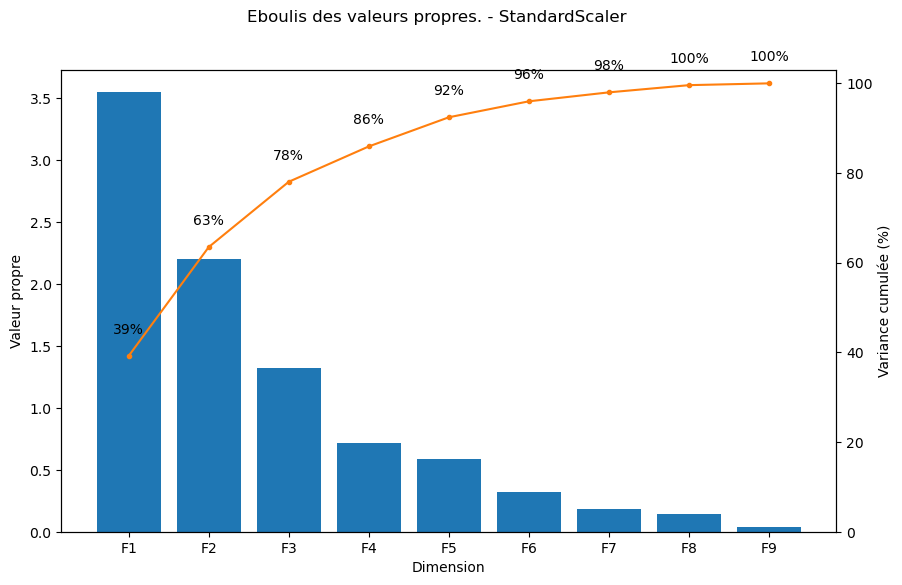

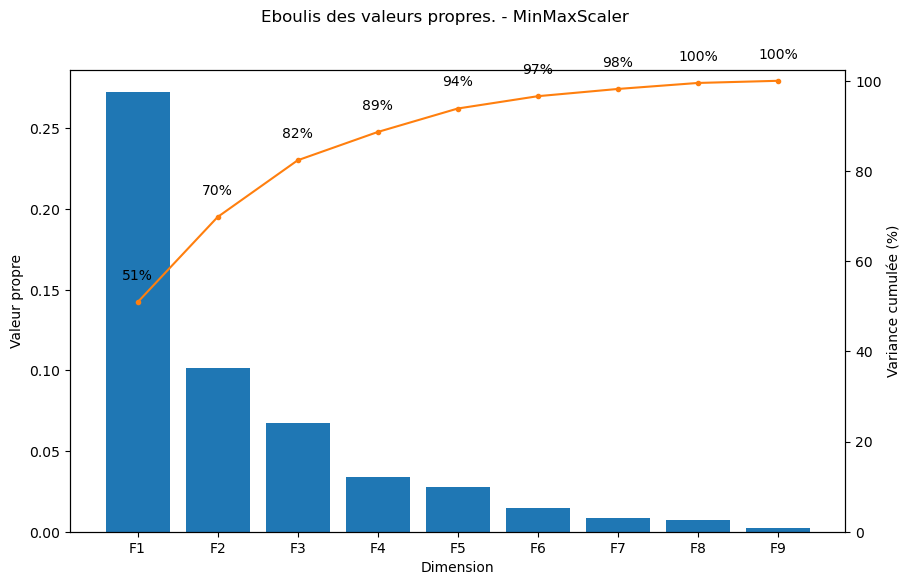

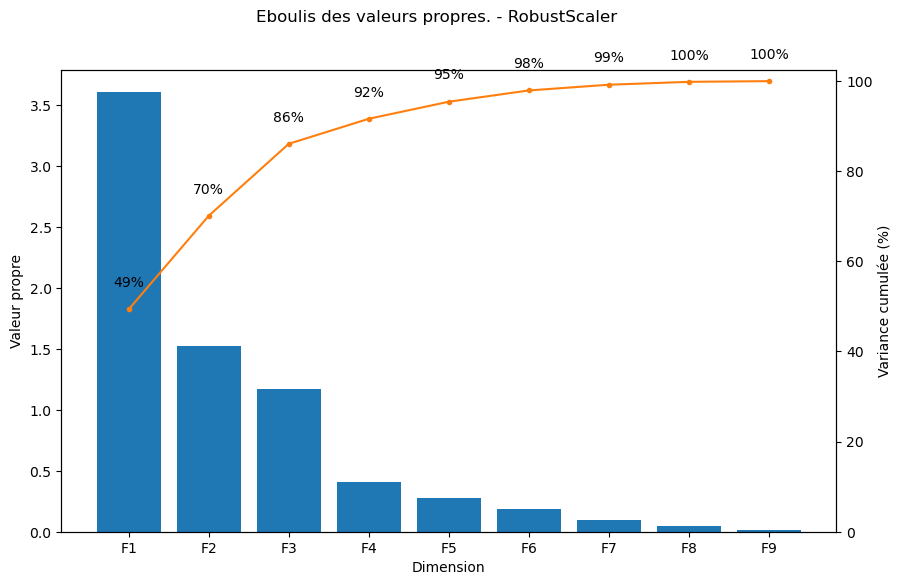

In [17]:
from sklearn.decomposition import PCA
import matplotlib.ticker as ticker

# Fonction pour effectuer l'ACP et afficher la variance cumulée
def pca_cumulative_variance(df, scaler_type):
    # Sélection des colonnes numériques
    numeric_cols = df.select_dtypes(include=np.number).columns
    df_numeric = df[numeric_cols]

    # Application du scaler
    if scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        scaler = MinMaxScaler()
    elif scaler_type == 'RobustScaler':
        scaler = RobustScaler()
    else:
        raise ValueError("Scaler non supporté. Utilisez 'StandardScaler', 'MinMaxScaler' ou 'RobustScaler'.")

    scaled_data = scaler.fit_transform(df_numeric)

    # Application de l'ACP
    pca = PCA()
    pca = pca.fit(scaled_data)

    # Initialisation des variables
    components = np.arange(1, (len(pca.explained_variance_) + 1))
    components = [f'F{x}' for x in components]
    cum_variance_ratio = pca.explained_variance_ratio_.cumsum()

    # Tracer les graphiques
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    ax1.bar(components, pca.explained_variance_, color='C0')
    ax2.plot(components, cum_variance_ratio, color='C1', marker='.')
    for x, y in enumerate(cum_variance_ratio):
        ax2.text(x, (y + 0.05), f'{y:.0%}', ha='center')

    # Définir la limite basse et le format de l'axe secondaire
    ax2.set_ylim(bottom=0)
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: round(x * 100)))

    ax1.set_xlabel('Dimension')
    ax1.set_ylabel('Valeur propre')
    ax2.set_ylabel('Variance cumulée (%)')

    fig.suptitle(f'Eboulis des valeurs propres. - {scaler_type}')
    plt.show()

# Application de la fonction pour chaque scaler
scalers = ['StandardScaler', 'MinMaxScaler', 'RobustScaler']
for scaler in scalers:
    pca_cumulative_variance(df_final, scaler)


Les deux premières composantes principales correspondent à un pourcentage de variabilité de 70 % pour le robustscaler et MinMaxscaler et 63% pour le Standarscaler. La représentation sur ces deux dimensions est donc de qualité suffisante, c'est ce nombre que nous choisissons de garder pour la suite.

Miantenant, on étudie les liaisons entre nos variables d'origine et les composantes principales grâce au  cercle des corrélations en utilisant une une fonction qui va nous permettre de tracer les cercles en fonction des composantes principales que l'on souhaite afficher pour chaque scaler.

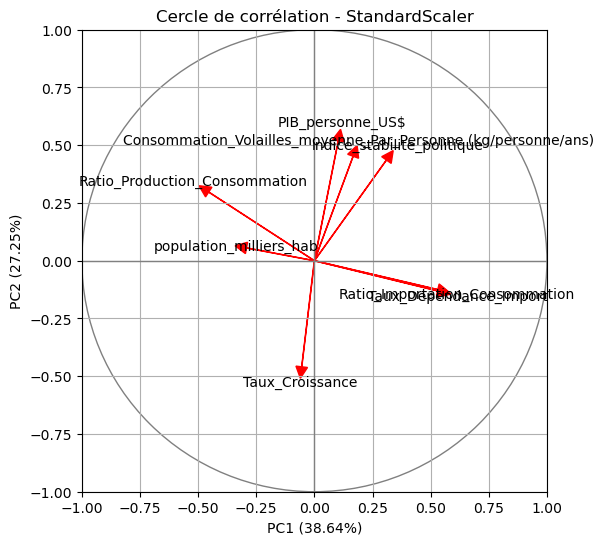

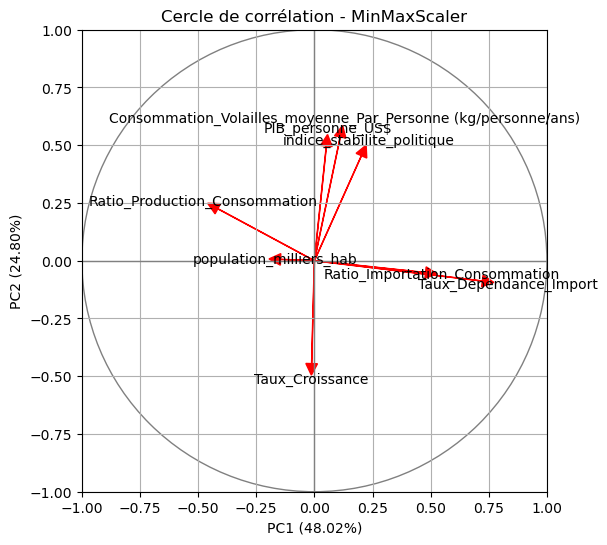

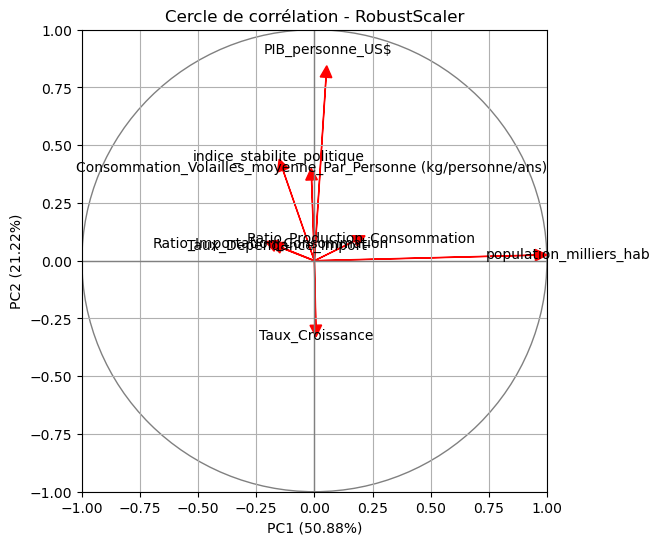

In [18]:
# Etape 2:

def plot_correlation_circle(pca, components, features, scaler_type):
    pc1 = components[0]
    pc2 = components[1]

    fig, ax = plt.subplots(figsize=(6, 6))
    circle = plt.Circle((0, 0), 1, color='gray', fill=False)
    ax.add_artist(circle)

    for i in range(len(pc1)):
        ax.arrow(0, 0, pc1[i], pc2[i], head_width=0.05, head_length=0.05, fc='red', ec='red')
        ax.text(pc1[i] * 1.15, pc2[i] * 1.15, features[i], color='black', ha='center', va='center')

    variance_ratio = pca.explained_variance_ratio_
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel(f'PC1 ({variance_ratio[0]*100:.2f}%)')
    ax.set_ylabel(f'PC2 ({variance_ratio[1]*100:.2f}%)')
    ax.set_title(f'Cercle de corrélation - {scaler_type}')
    plt.grid()
    plt.axhline(0, color='grey', lw=1)
    plt.axvline(0, color='grey', lw=1)
    plt.show()

def pca_analysis_and_correlation_circle(df, scaler_type):
    # Sélection des colonnes numériques en excluant 'Cluster'
    numeric_cols = [col for col in df.select_dtypes(include=np.number).columns if col != 'Cluster']
    df_numeric = df[numeric_cols]

    # Application du scaler
    if scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        scaler = MinMaxScaler()
    elif scaler_type == 'RobustScaler':
        scaler = RobustScaler()
    else:
        raise ValueError("Scaler non supporté. Utilisez 'StandardScaler', 'MinMaxScaler' ou 'RobustScaler'.")

    scaled_data = scaler.fit_transform(df_numeric)

    # Application de l'ACP
    pca = PCA()
    pca = pca.fit(scaled_data)

    # Projections des variables
    components = pca.components_

    # Tracer le cercle de corrélation
    plot_correlation_circle(pca, components, numeric_cols, scaler_type)

# Application de la fonction pour chaque scaler
scalers = ['StandardScaler', 'MinMaxScaler', 'RobustScaler']
for scaler in scalers:
    pca_analysis_and_correlation_circle(df_final, scaler)


**Les variables les plus corrélées à PC1 :**
    
    Standart Sclaer :  ratio_Importation_consommation, taux_de_dependance_aux_importations,stabilité politique
    Robust Scaler : Population_milliers_hab, ration production consommation
    MinMax Scaler : ratio_Importation_consommation, taux_de_dependance_aux_importations
    
**Les variables les plus corrélées à PC2 :**

    Standart Sclaer :  ratio_production_consommation, Pib
    Robust Scaler : stabilité politique, pib
    MinMax Scaler : consommation_volailles_moyenne, pib
    
 

On peut également afficher les corrélations sous forme de matrice.



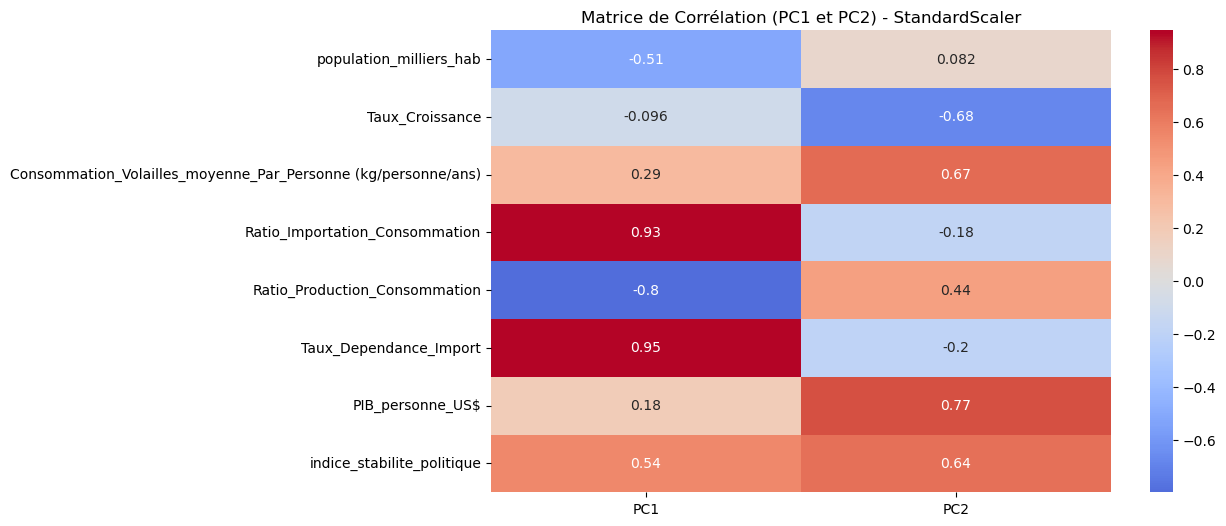

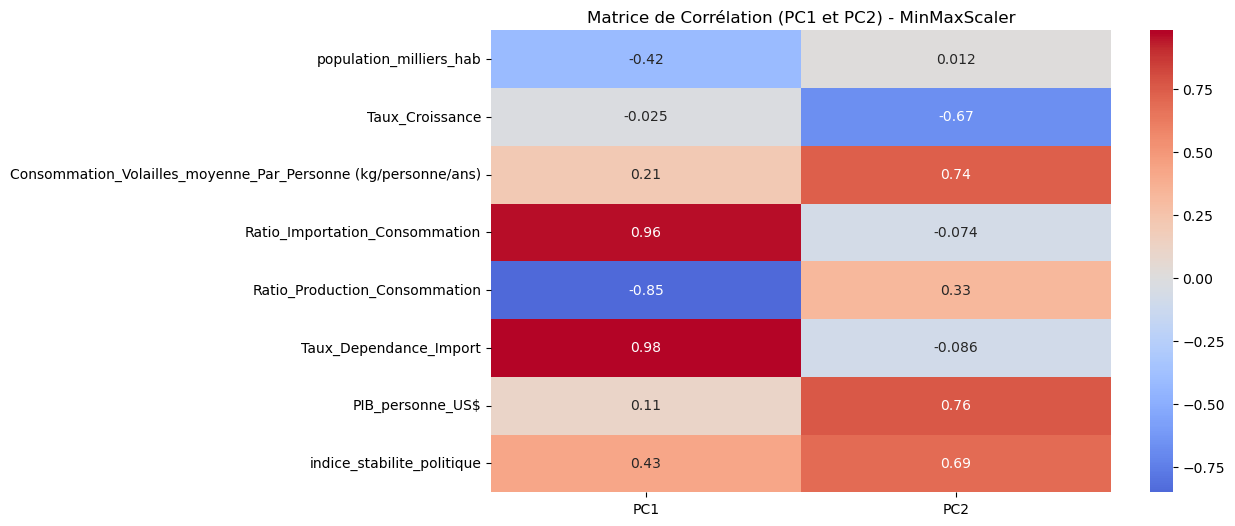

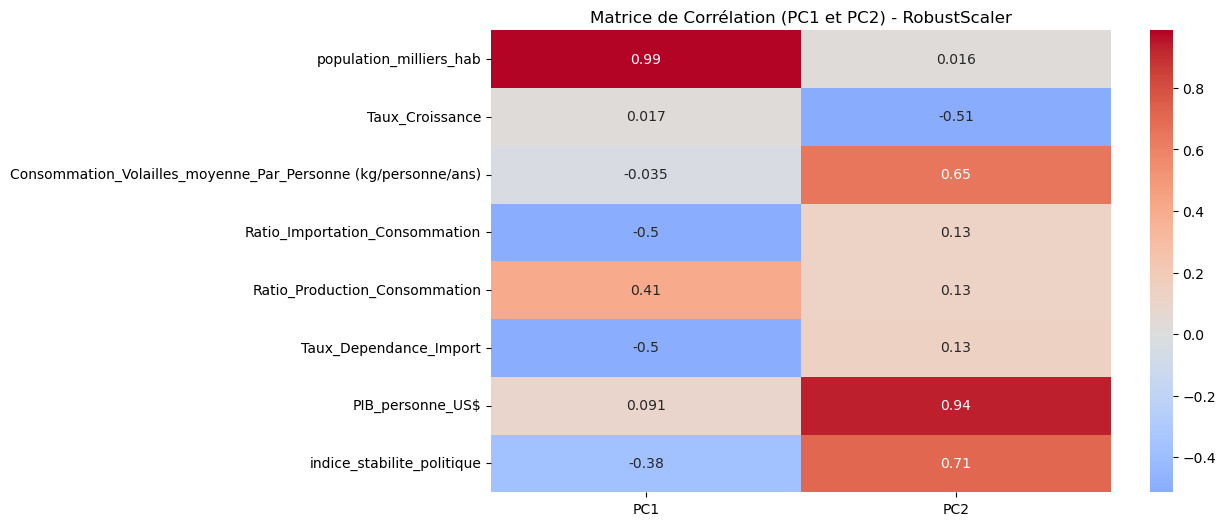

In [19]:

def plot_correlation_matrix(pca, scaled_data, features, scaler_type):
    # Calculer les composantes principales
    pca_components = pca.transform(scaled_data)[:, :2]  # Prendre seulement les deux premières composantes

    # Calculer les coefficients de corrélation
    correlation_matrix = np.corrcoef(scaled_data.T, pca_components.T)[:len(features), len(features):]

    # Créer un DataFrame pour la matrice de corrélation
    corr_df = pd.DataFrame(correlation_matrix, index=features, columns=['PC1', 'PC2'])
    
    # Tracer la matrice de corrélation
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
    plt.title(f'Matrice de Corrélation (PC1 et PC2) - {scaler_type}')
    plt.show()

def pca_analysis_and_correlation_matrix(df, scaler_type):
    # Sélection des colonnes numériques en excluant 'Cluster'
    numeric_cols = [col for col in df.select_dtypes(include=np.number).columns if col != 'Cluster']
    df_numeric = df[numeric_cols]

    # Application du scaler
    if scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        scaler = MinMaxScaler()
    elif scaler_type == 'RobustScaler':
        scaler = RobustScaler()
    else:
        raise ValueError("Scaler non supporté. Utilisez 'StandardScaler', 'MinMaxScaler' ou 'RobustScaler'.")

    scaled_data = scaler.fit_transform(df_numeric)

    # Application de l'ACP
    pca = PCA()
    pca = pca.fit(scaled_data)

    # Tracer la matrice de corrélation
    plot_correlation_matrix(pca, scaled_data, numeric_cols, scaler_type)

# Application de la fonction pour chaque scaler
scalers = ['StandardScaler', 'MinMaxScaler', 'RobustScaler']
for scaler in scalers:
    pca_analysis_and_correlation_matrix(df_final, scaler)


La matrice confirme les observations faites sur les cercles des corrélations.



Maintenant que nous avons créé de nouvelles variables, nous pouvons projeter les pays sur des plans composés par ces dernières. On crée une autre fonction qui va nous permettre tracer les scater plot des pays.

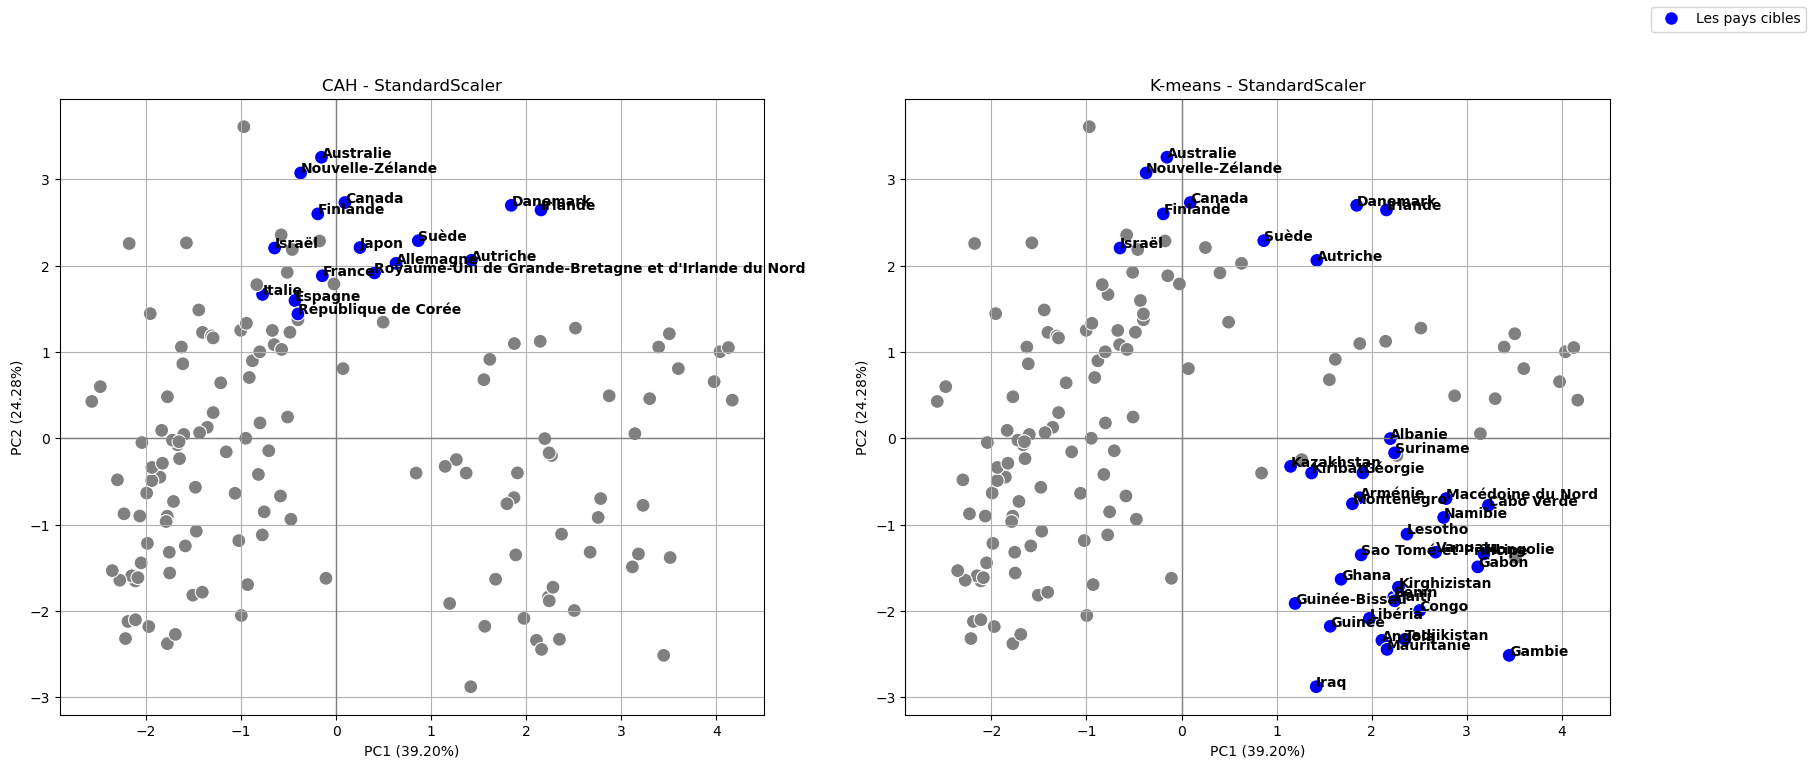

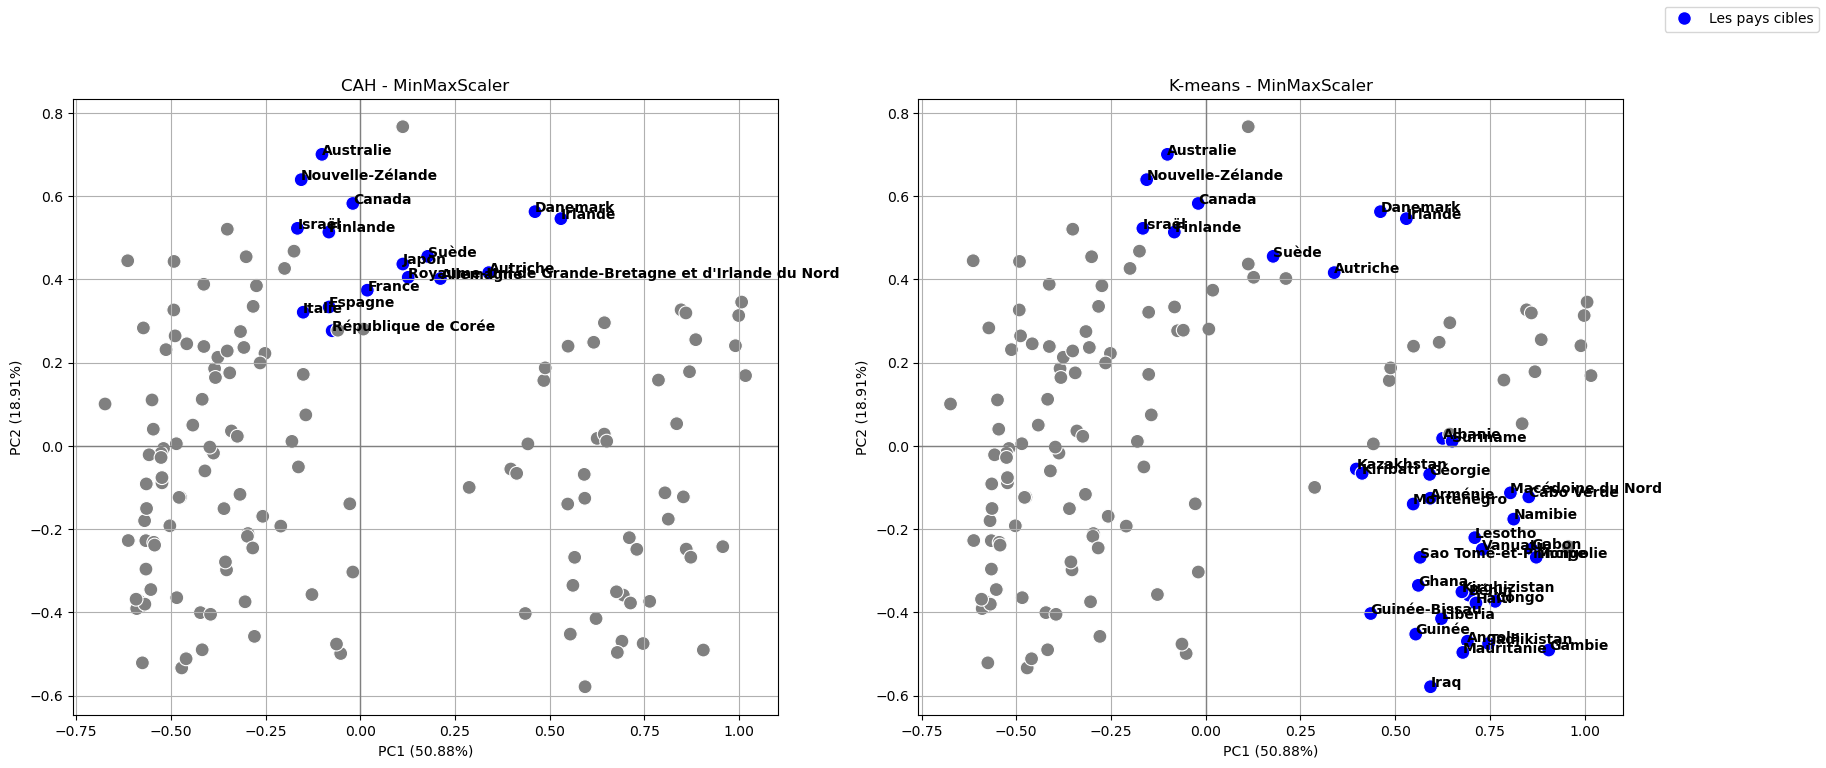

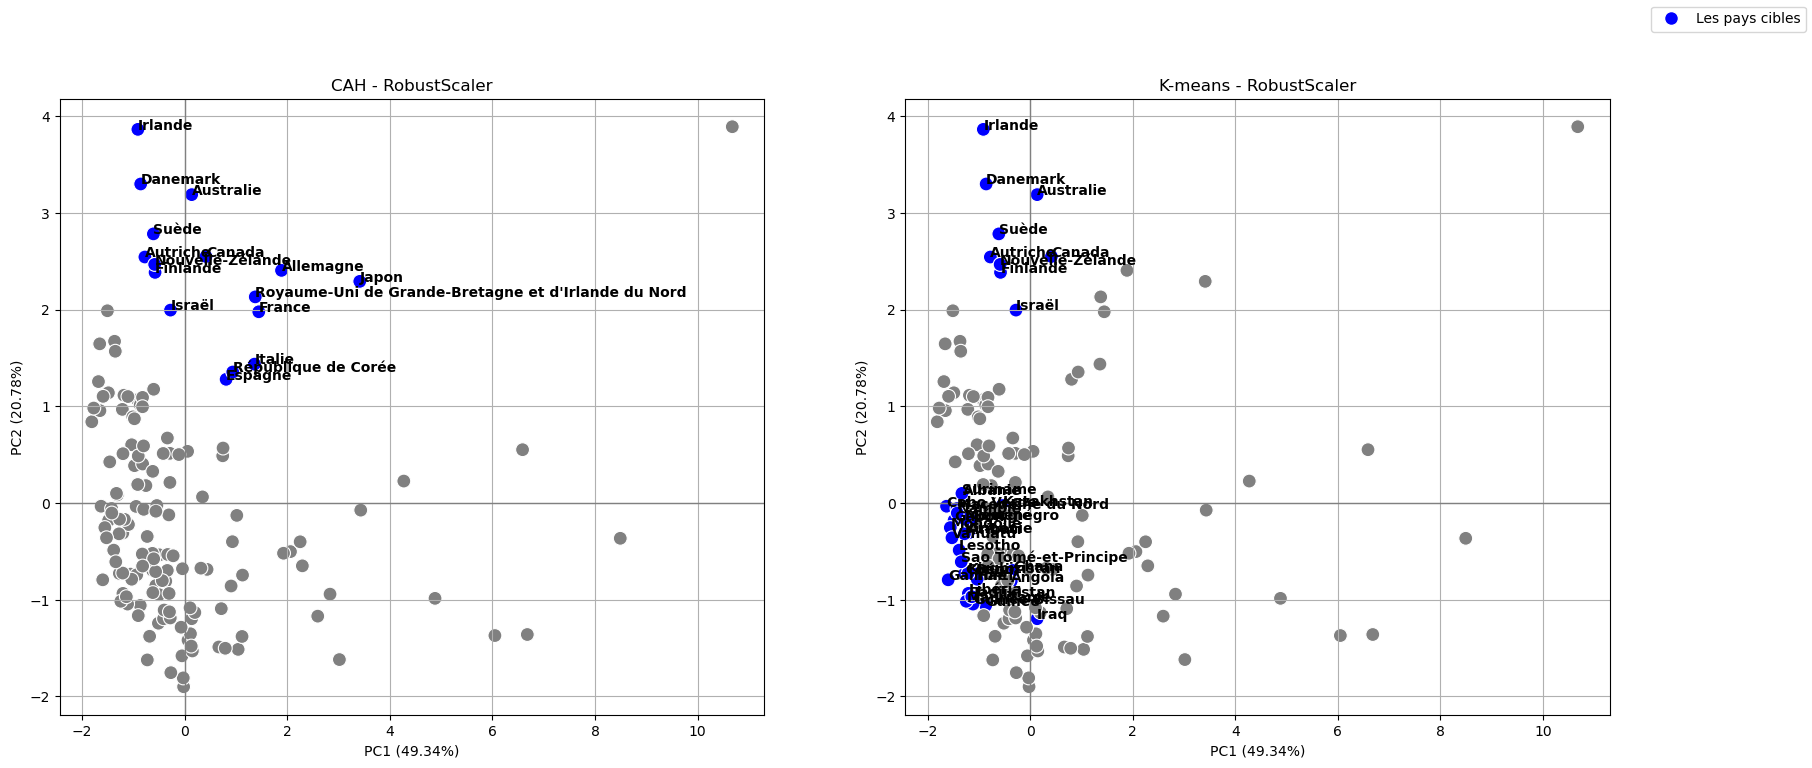

In [20]:
# Fonction pour représenter les individus sur les plans factoriels PC1 et PC2 avec coloration des pays ciblés
def plot_individuals_pca(X_scaled, pca, target_countries, ax, title):
    # Calculer les composantes principales
    X_pca = pca.transform(X_scaled)

    # Créer un DataFrame pour les données transformées par PCA
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Zone'] = df_final['Zone']  # Ajouter la colonne des noms de pays pour la référence
    pca_df['Category'] = pca_df['Zone'].apply(lambda x: 'Target' if x in target_countries else 'Other')

    # Tracer le graphique avec couleurs personnalisées
    colors = {'Target': 'blue', 'Other': 'gray'}
    sns.scatterplot(x='PC1', y='PC2', hue='Category', data=pca_df, palette=colors, legend=False, s=100, ax=ax)
    
    # Annoter les pays cibles
    for i in range(len(pca_df)):
        if pca_df['Category'].iloc[i] == 'Target':
            ax.text(pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i], pca_df['Zone'].iloc[i],
                    horizontalalignment='left', size='medium', color='black', weight='semibold')
    
    ax.set_title(title)
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
    ax.grid(True)
    ax.axhline(0, color='grey', lw=1)
    ax.axvline(0, color='grey', lw=1)

# Liste des pays à cibler pour chaque méthode
cah_countries = ['Allemagne', 'Australie', 'Autriche', 'Canada', 'Danemark', 'Espagne', 'Finlande', 'France', 'Irlande', 'Israël', 'Italie', 'Japon', 'Nouvelle-Zélande', 'République de Corée', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Suède']
kmeans_countries = ['Australie', 'Autriche', 'Canada', 'Danemark', 'Finlande', 'Irlande', 'Israël', 'Nouvelle-Zélande', 'Suède', 'Albanie', 'Angola', 'Arménie', 'Bénin', 'Cabo Verde', 'Congo', 'Gabon', 'Gambie', 'Géorgie', 'Ghana', 'Guinée', 'Guinée-Bissau', 'Haïti', 'Iraq', 'Kazakhstan', 'Kirghizistan', 'Kiribati', 'Lesotho', 'Libéria', 'Macédoine du Nord', 'Mauritanie', 'Mongolie', 'Monténégro', 'Namibie', 'Sao Tomé-et-Principe', 'Suriname', 'Tadjikistan', 'Vanuatu']

# Sélection des colonnes numériques
numeric_cols = df_final.select_dtypes(include=np.number).columns
df_numeric = df_final[numeric_cols]

# Application de l'ACP et tracé des résultats pour chaque scaler
scalers = ['StandardScaler', 'MinMaxScaler', 'RobustScaler']
for scaler_type in scalers:
    # Application du scaler
    if scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        scaler = MinMaxScaler()
    elif scaler_type == 'RobustScaler':
        scaler = RobustScaler()
    else:
        raise ValueError("Scaler non supporté. Utilisez 'StandardScaler', 'MinMaxScaler' ou 'RobustScaler'.")
    
    X_scaled = scaler.fit_transform(df_numeric)

    # Appliquer PCA avec 2 composantes principales
    pca = PCA(n_components=2)
    pca.fit(X_scaled)

    # Créer une figure avec deux sous-graphes côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Tracer la représentation des individus avec coloration des pays ciblés pour CAH
    plot_individuals_pca(X_scaled, pca, cah_countries, axes[0], f'CAH - {scaler_type}')

    # Tracer la représentation des individus avec coloration des pays ciblés pour K-means
    plot_individuals_pca(X_scaled, pca, kmeans_countries, axes[1], f'K-means - {scaler_type}')

    # Afficher les légendes
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Les pays cibles')]
    fig.legend(handles=handles, loc='upper right')

    plt.show()


=>  Les Les pays cibles (en bleu) sont clairement visibles et annotés sur chaque graphique par les 2 méthodes de clustering. . Cependant la méthode CAH regroupe mieux les pays.
  
=> Les pays sont regroupés de manière plus cohérente ( à gauche) avec le RobustScaler. Cette méthode de mise à l'échelle permet de mieux séparer les groupes dans l'espace des composantes principales.

# Recommandation ciblée 


Pour rappel, notre entreprise souhaite démarrer son activité à l'internationale. Pour affiner notre recommandation, on retire dans un premier temps les pays qui sont loin de la France (logistique) et/ou les pays ayant une population trop importante (capacité à répondre à la demande).

In [21]:
# Pays proches de la France (logistique)
pays_proches = ['Allemagne', 'Autriche', 'Belgique', 'Espagne', 'Italie', 'Luxembourg', 'Pays-Bas', 'Portugal', 'Suisse', 
                'Royaume-Uni', 'Irlande', 'Danemark', 'Suède', 'Norvège', 'Finlande']

# Limite de population acceptable ( < 83 millions)
population_limite = 83000  # en milliers d'habitants

# Filtrer les pays par proximité géographique et population
pays_proches_set = set(pays_proches)

# Fonction de filtrage utilisant le DataFrame
def filtrer_pays(df, pays_liste, pays_proches_set, population_limite):
    df_filtered = df[df['Zone'].isin(pays_liste) & 
                     df['Zone'].isin(pays_proches_set) & 
                     (df['population_milliers_hab'] <= population_limite)]
    return df_filtered['Zone'].tolist()

# Appliquer le filtrage
pays_retenus_cah_filtre = filtrer_pays(df_final, cah_countries, pays_proches_set, population_limite)
pays_retenus_kmeans_filtre = filtrer_pays(df_final, kmeans_countries, pays_proches_set, population_limite)

# Afficher les résultats filtrés
print(f'Pays retenus après filtrage :')
print(f'- CAH : {pays_retenus_cah_filtre}')
print(f'- k-means : {pays_retenus_kmeans_filtre}')

# Afficher les différences entre les listes filtrées
pays_differents_filtre = set(pays_retenus_cah_filtre).symmetric_difference(set(pays_retenus_kmeans_filtre))
print(f'Les pays qui diffèrent après filtrage sont : {pays_differents_filtre}')


Pays retenus après filtrage :
- CAH : ['Allemagne', 'Autriche', 'Danemark', 'Espagne', 'Finlande', 'Irlande', 'Italie', 'Suède']
- k-means : ['Autriche', 'Danemark', 'Finlande', 'Irlande', 'Suède']
Les pays qui diffèrent après filtrage sont : {'Espagne', 'Allemagne', 'Italie'}


In [22]:
# Combiner les deux listes de pays retenus et supprimer les doublons
pays_retenus_combines = list(set(pays_retenus_cah_filtre + pays_retenus_kmeans_filtre))

# Filtrer le DataFrame pour obtenir uniquement les pays retenus
df_pays_retenus = df_final[df_final['Zone'].isin(pays_retenus_combines)]

# Sélectionner les colonnes numériques (indicateurs)
indicateurs = df_pays_retenus.select_dtypes(include=[np.number]).columns

# Exclure la colonne 'Cluster' si elle existe
if 'Cluster' in indicateurs:
    indicateurs = indicateurs.drop('Cluster')

# Afficher les indicateurs pour les pays retenus sans la colonne 'Cluster'
df_indicateurs_pays_retenus = df_pays_retenus[['Zone'] + list(indicateurs)]

# Afficher le DataFrame
print("Caractéristiques des pays retenus après filtrage (par CAH et k-means) :")
display(df_indicateurs_pays_retenus)


Caractéristiques des pays retenus après filtrage (par CAH et k-means) :


,Zone,population_milliers_hab,Taux_Croissance,Consommation_Volailles_moyenne_Par_Personne (kg/personne/ans),Ratio_Importation_Consommation,Ratio_Production_Consommation,Taux_Dependance_Import,PIB_personne_US$,indice_stabilite_politique
3,Allemagne,82658.409,0.116470,19.47,52.318959,94.074709,49.24,44670.222282,0.59
10,Autriche,8819.901,0.540452,18.20,68.526348,92.199086,61.11,47429.535841,1.05
37,Danemark,5732.274,0.412628,28.98,80.061979,104.140769,79.64,57888.203513,0.87
42,Espagne,46647.428,0.748916,30.39,14.460904,106.869611,13.59,28190.806667,0.28
49,Finlande,5511.371,0.347854,18.76,15.474888,124.766281,12.03,46412.760009,1.08
67,Irlande,4753.279,1.353284,25.82,80.665095,89.627883,85.34,70491.993292,1.00
69,Italie,60673.701,0.373523,18.88,8.467774,114.795080,7.89,32694.406225,0.31
133,Suède,9904.896,0.645176,16.60,51.088280,95.486427,38.53,53788.877499,0.98


Notre top 5 final porte sur les pays suivants :



In [23]:
# Liste des top 5 pays
top_5_pays = ['Allemagne', 'Suède', 'Autriche', 'Irlande', 'Danemark']



# Afficher le DataFrame
print("Top 5 des pays retenus des résultats des deux méthodes k-means et CAH:")
display(top_5_pays )


Top 5 des pays retenus des résultats des deux méthodes k-means et CAH:


['Allemagne', 'Suède', 'Autriche', 'Irlande', 'Danemark']

=> En ciblant ces pays, notre entreprise peut s'assurer que ses efforts sont concentrés sur des segments de marché bien définis et cohérents. Cela peut augmenter l'efficacité des campagnes marketing.

Remarque : Les autres pays ont étaient éliminés apés avoir réexaminer les valeurs des différents indicateurs!